# Analysis of the Brighter Fatter Effect in MIRI DATA using the MIRI F5860W filter.

In this notebook we explore the linearity of the detector ramps of miri imager data (PID 1464). We formulate a correction for the BFE and compare this to the uncorrected and standard linearized ramps. We also introduce a correction for the RSCD effect.


In [1]:
import os, pathlib

In [2]:
ROOT_DIR = pathlib.Path('/mnt/beegfs/krause/miri_comm/')
PROJECT_DIR = ROOT_DIR / 'miri_linearity/'

In [3]:
os.environ["CRDS_PATH"] = str(ROOT_DIR / "crds_cache/")
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
os.environ["CRDS_CONTEXT"] = "jwst_1263.pmap"

In [4]:
os.environ['CASCADE_WARNINGS']='on'
os.environ['OPENBLAS_NUM_THREADS'] = '2'
os.environ['GOTO_NUM_THREADS'] = '2'
os.environ['OMP_NUM_THREADS'] = '2'

In [132]:
import gc, shutil, glob
import pdb
import datetime
import warnings
from tqdm.notebook import tqdm
import psutil

import numba as nb
import numpy as np
import scipy
import scipy.ndimage
from scipy import signal
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

from astropy.io import fits
from astropy.io import ascii as ap_ascii
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch, HistEqStretch,MinMaxInterval, LogStretch
#from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import ImageNormalize
from astropy.visualization import simple_norm
import astropy.units as u
from astropy.stats import SigmaClip
from astropy.stats import sigma_clip, mad_std
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

from operator import add

import ray

from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.background import Background2D
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

In [6]:
import jwst
from stdatamodels.jwst import datamodels # JWST datamodels
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import calwebb_detector1
from jwst.datamodels.linearity import LinearityModel

In [7]:
print("pipeline version: ", jwst.__version__)

pipeline version:  1.15.1


In [8]:
from cascade_jitter.utilities import create_mask_from_dq

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

2024-08-29 13:27:33,557 - stpipe - WARNING - /tmp/ipykernel_864850/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



In [11]:
sns.set_context("talk", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_style("white", {"xtick.bottom": True, "ytick.left": True})
my_color = sns.color_palette("gist_rainbow_r", 150)

In [12]:
target = 'PID1464'
data_dir = PROJECT_DIR / f'data/{target}/uncal/'

In [13]:
data_files = list(data_dir.glob('jw*uncal.fits'))
data_files.sort()
print(f'{len(data_files)} uncal files found' )

1 uncal files found


# The Webb PSF model

In [14]:
os.environ["WEBBPSF_PATH"] = str(ROOT_DIR / "webbpsf-data")
import webbpsf

In [15]:
sim_inst = webbpsf.setup_sim_to_match_file(str(data_files[0]))
sim_inst.options['charge_diffusion_sigma'] = 0.034
model_psf = sim_inst.calc_psf(fov_pixels=34, oversample=1)

Setting up sim to match /mnt/beegfs/krause/miri_comm/miri_linearity/data/PID1464/uncal/jw01464005001_02101_00001_mirimage_uncal.fits

MAST OPD query around UTC: 2022-04-15T18:31:13.287
                        MJD: 59684.7716815625

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022041506-NRCA3_FP1-2.fits
	Date (MJD):	 59684.4798
	Delta time:	 -0.2919 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/O2022041601-NRCA3_FP1-1.fits
	Date (MJD):	 59684.9945
	Delta time:	 0.2228 days
User requested choosing OPD time closest in time to 2022-04-15T18:31:13.287, which is O2022041601-NRCA3_FP1-1.fits, delta time 0.223 days
Importing and format-converting OPD from /mnt/beegfs/krause/miri_comm/webbpsf-data/MAST_JWST_WSS_OPDs/O2022041601-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Configured simulation instrument for:
    Instrument: MIRI
    Filter: F560W
    Detector: MIRIM
    Apername: MIRIM_FUL

# The JWST pipeline and calibration files

In [16]:
pipe = Detector1Pipeline()

2024-08-29 13:27:46,576 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2024-08-29 13:27:46,578 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2024-08-29 13:27:46,578 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2024-08-29 13:27:46,580 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2024-08-29 13:27:46,580 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2024-08-29 13:27:46,581 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2024-08-29 13:27:46,583 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2024-08-29 13:27:46,584 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2024-08-29 13:27:46,585 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2024-08-29 13:27:46,586 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-08-29 13:27

### Linearity

In [17]:
linearity_data_model = LinearityModel(pipe.linearity.get_reference_file(data_files[0], 'linearity'))

lin_coeffs = linearity_data_model.coeffs[:, :, 4:-4]
ncoeffs = lin_coeffs.shape[0]

def linearity_correction(data_in, lin_coeffs):
    ncoeffs = lin_coeffs.shape[0]
    # Accumulate the polynomial terms into the corrected counts
    scorr = data_in * lin_coeffs[ncoeffs - 1]
    for j in range(ncoeffs - 2, 0, -1):
        scorr = data_in * (scorr + lin_coeffs[j])
    scorr += lin_coeffs[0]
    return scorr

2024-08-29 13:27:57,392 - stpipe - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-08-29 13:27:57,407 - stpipe - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


### Detector Gain

In [18]:
from jwst.datamodels.gain import GainModel
gain_data_model = GainModel(pipe.gain_scale.get_reference_file(data_files[0], 'gain'))

print(f'Used filter for gain measurement: {gain_data_model.meta.instrument.filter}')
detector_gain_image_crds = gain_data_model.data[:, 4:-4]
detector_gain_crds = np.mean(detector_gain_image_crds)
print(f'Gain value from reference file: {detector_gain_crds}')

2024-08-29 13:28:03,617 - CRDS - INFO -  Fetching  /mnt/beegfs/krause/miri_comm/crds_cache/references/jwst/miri/jwst_miri_gain_0039.fits   12.7 M bytes  (1 / 1 files) (0 / 12.7 M bytes)


Used filter for gain measurement: F560W
Gain value from reference file: 3.929994583129883


### IPC

Note we will use the IPC kernel determined from the Trappist-1b data. The standard CRDS kernel is only used for comparison.

In [19]:
from jwst.datamodels.ipc import IPCModel
ipc_data_model = IPCModel(pipe.ipc.get_reference_file(data_files[0], 'ipc'))
ipc_kernel = ipc_data_model.data

In [20]:
print(f'CRDS IPC deconvolution kernel: \n {ipc_kernel}')

CRDS IPC deconvolution kernel: 
 [[-0.01150118 -0.02768889 -0.01150118]
 [-0.04001785  1.1814182  -0.04001785]
 [-0.01150118 -0.02768889 -0.01150118]]


#### Quick check ipc convolution kernel

In [21]:
delta = np.zeros((3, 3))
delta[1,1] = 1
ipc_crds_conv_kernel = np.fft.fftshift(np.fft.ifftn( np.fft.fftn(delta)/np.fft.fftn(ipc_kernel) ).real)

In [22]:
print(f'CRDS IPC Convolution kernel: \n {ipc_crds_conv_kernel}')
print(f'Check kernel (should be delta function): \n {convolve(ipc_kernel, ipc_crds_conv_kernel)}')

CRDS IPC Convolution kernel: 
 [[0.011      0.022      0.011     ]
 [0.031      0.85000001 0.031     ]
 [0.011      0.022      0.011     ]]
Check kernel (should be delta function): 
 [[1.4808495e-03 8.6218136e-04 1.4808495e-03]
 [1.4935794e-03 1.0000000e+00 1.4935794e-03]
 [1.4808495e-03 8.6218136e-04 1.4808495e-03]]


### We will use the IPC kernel determined from the F1280W obserations of Trapist-1b

In [23]:
def define_ipc_kernel(alpha_v, alpha_h, alpha_d, alpha_v2, alpha_h2, alpha_d2):
    ipc = np.zeros((5,5))
    
    alpha_vd = (alpha_v2 + alpha_d2)/2.0
    alpha_hd = (alpha_h2 + alpha_d2)/2.0 
    
    ipc[2, 2] = 1.0 - 2*alpha_v - 2*alpha_h - 4*alpha_d - 2*alpha_v2 - 2*alpha_h2 - 4*alpha_d2 - 4*alpha_vd - 4*alpha_hd
    ipc[2, 1] = ipc[2, 3] = alpha_h
    ipc[1, 2] = ipc[3, 2] = alpha_v
    ipc[1, 1] = ipc[3, 3] = ipc[1, 3] = ipc[3, 1] = alpha_d
    
    ipc[2, 0] = ipc[2, 4] = alpha_h2
    ipc[0, 2] = ipc[4, 2] = alpha_v2
    
    ipc[0, 0] = ipc[4, 4] = ipc[0, 4] = ipc[4, 0] = alpha_d2
    
    ipc[0, 1] = ipc[4, 1] = ipc[0, 3] = ipc[4, 3] = alpha_vd
    ipc[1, 0] = ipc[1, 4] = ipc[3, 0] = ipc[3, 4] = alpha_hd
    
    
    return ipc

#### Create the kernel using the parameters determined from the trappist-1b dataset

In [24]:
new_IPC_kernel = define_ipc_kernel(0.0215, 0.0321, 0.0077, 0.0028, 0.0046, 0.0012)

In [25]:
delta = np.zeros((5, 5))
delta[2,2] = 1
ipc_kernel = np.fft.fftshift(np.fft.ifftn( np.fft.fftn(delta)/np.fft.fftn(new_IPC_kernel) ).real)

In [26]:
print(f'Corrected IPC deconvolution kernel: \n {ipc_kernel}')
print(f'Check kernel (should be delta function): \n {convolve(ipc_kernel, new_IPC_kernel)}')

Corrected IPC deconvolution kernel: 
 [[-9.74991696e-04 -1.79470748e-03 -2.54803277e-03 -1.79470748e-03
  -9.74991696e-04]
 [-2.74281331e-03 -8.43532278e-03 -3.00472997e-02 -8.43532278e-03
  -2.74281331e-03]
 [-3.96178441e-03 -4.60287761e-02  1.22096313e+00 -4.60287761e-02
  -3.96178441e-03]
 [-2.74281331e-03 -8.43532278e-03 -3.00472997e-02 -8.43532278e-03
  -2.74281331e-03]
 [-9.74991696e-04 -1.79470748e-03 -2.54803277e-03 -1.79470748e-03
  -9.74991696e-04]]
Check kernel (should be delta function): 
 [[2.79391335e-04 1.93551782e-04 2.12532634e-04 1.93551782e-04
  2.79391335e-04]
 [3.32636748e-04 4.56198368e-05 1.66533017e-05 4.56198368e-05
  3.32636748e-04]
 [4.38277112e-04 3.64725056e-05 1.00000000e+00 3.64725056e-05
  4.38277112e-04]
 [3.32636748e-04 4.56198368e-05 1.66533017e-05 4.56198368e-05
  3.32636748e-04]
 [2.79391335e-04 1.93551782e-04 2.12532634e-04 1.93551782e-04
  2.79391335e-04]]


#### Define the IPC correction function

In [27]:
def ipc_correction(data_in, ipc_kernel):
    ipc_corrected_data = np.ma.harden_mask(data_in.copy())
    if ipc_corrected_data.ndim == 4:
        nints = ipc_corrected_data.shape[0]
        nframes = ipc_corrected_data.shape[1]
        for iint in range(nints):
            for iframe in range(nframes):
                if np.all(ipc_corrected_data[iint, iframe, ...].mask):
                    continue
                ipc_corrected_data[iint, iframe, ...] = \
                   convolve(ipc_corrected_data[iint, iframe, ...], ipc_kernel ,boundary='extend', nan_treatment='interpolate', normalize_kernel=True)
    elif ipc_corrected_data.ndim == 3:
        nframes = ipc_corrected_data.shape[0]
        for iframe in range(nframes):
            if np.all(ipc_corrected_data[iframe, ...].mask):
                continue
            ipc_corrected_data[iframe, ...] = \
               convolve(ipc_corrected_data[iframe, ...], ipc_kernel ,boundary='extend', nan_treatment='interpolate', normalize_kernel=True)
    else:
        ipc_corrected_data = \
               convolve(ipc_corrected_data, ipc_kernel ,boundary='extend', nan_treatment='interpolate', normalize_kernel=True)
    return np.ma.soften_mask(ipc_corrected_data)

### Dark current

In [28]:
from jwst.datamodels.darkMIRI import DarkMIRIModel

dark_data_model = DarkMIRIModel(pipe.dark_current.get_reference_file(data_files[0], 'dark'))

In [29]:
imager_darks = dark_data_model.data[...,4:-4]

#### Define the dark current correction function

Note that the darks+reset correction is deferent for the very first intagration.

In [30]:
def dark_correction(data_in, darks, is_first=False, is_second=False):
    dark_corrected_data = np.ma.harden_mask(data_in.copy())
    if dark_corrected_data.ndim == 4:
        nints = dark_corrected_data.shape[0]
        nframes = dark_corrected_data.shape[1]
        dark_corrected_data[0, ...] -= darks[0, :nframes, ...]
        if nints >= 1:
            dark_corrected_data[1, ...] -= darks[1, :nframes, ...]
        if (nints >= 2):
            if (darks.shape[0]==3):
                dark_corrected_data[2:, ...] -= darks[2, :nframes, ...]
            else:
                dark_corrected_data[2:, ...] -= darks[1, :nframes, ...]
    else:
        nframes = dark_corrected_data.shape[0]
        if is_first:
            dark_corrected_data -= darks[0, :nframes, ...]
        elif is_second | (darks.shape[0]==2):
            dark_corrected_data -= darks[1, :nframes, ...]
        else :
            dark_corrected_data -= darks[2, :nframes, ...]
    return np.ma.soften_mask(dark_corrected_data)

### RSCD

#### Define a best guess of the functional form of the RSCD effect. 

The functional form is some powerlaw decline with a certain time constant and the fraction of the maximum signal on the ramp. Note that the first integraton should not be corrected

In [31]:
time_constant_rscd = 1.3
rscd_constant = 0.001

def rscd_correction(data_in, time_constant_rscd, rscd_constant, detector_gain_image, is_first=False):
    
    rscd_corrected_data = np.ma.harden_mask(data_in.copy())
    break_value = 35000.0
    
    if rscd_corrected_data.ndim == 4:
        (nint, ngroups, ny, nx) = rscd_corrected_data.shape
        max_signal = (2*data_in[0:-1, ngroups-2, ...]-data_in[0:-1, ngroups-3, ...])[:, None, :, :]
        scaling = np.zeros_like(max_signal)
        rscd_correction_ramp =  np.zeros_like(rscd_corrected_data)
        scaling[max_signal<=break_value] = rscd_constant
        scaling[max_signal>break_value] = rscd_constant*(-0.35*max_signal[max_signal>break_value]/break_value + 1.35)
        rscd_correction_ramp[1:, ...] = np.ma.cumsum(scaling * max_signal * 
                                            np.tile(np.exp(-np.arange(ngroups)/time_constant_rscd)[None, :, None, None], (nint-1, 1, ny, nx)), axis=1)
        rscd_correction_ramp[0, ...] = 0.0
    else:
        (ngroups, ny, nx) = rscd_corrected_data.shape
        max_signal = (2*data_in[ngroups-2, ...]-data_in[ngroups-3, ...])[None, :, :]
        scaling = np.zeros_like(max_signal)
        scaling[max_signal<=break_value] = rscd_constant
        scaling[max_signal>break_value] = rscd_constant*(-0.35*max_signal[max_signal>break_value]/break_value + 1.35)
        rscd_correction_ramp = np.ma.cumsum(scaling * max_signal  *
                                            np.tile(np.exp(-np.arange(ngroups)/time_constant_rscd)[:, None, None], (1, ny, nx)), axis=0)        
        if is_first:
            rscd_correction_ramp[...] = 0.0
        
    rscd_corrected_data -= rscd_correction_ramp*detector_gain_image
    return np.ma.soften_mask(rscd_corrected_data), rscd_correction_ramp, max_signal, scaling

## Saturation

In [32]:
from jwst.datamodels.saturation import SaturationModel

saturation_data_model = SaturationModel(pipe.saturation.get_reference_file(data_files[0], 'saturation'))

2024-08-29 13:29:17,070 - stpipe - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-08-29 13:29:17,086 - stpipe - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


Saturation levels for linearized data

In [33]:
soft_saturation = linearity_correction(ipc_correction(saturation_data_model.data[:, 4:-4], ipc_kernel), lin_coeffs)

In [34]:
hard_saturation = linearity_correction(ipc_correction(np.ones((soft_saturation.shape))*2**16., ipc_kernel), lin_coeffs)

### BFE correction

Now we define the actual BFE correction procedure.
Following the appaoch in Coulton et al 2018 (AJ 155,  258) we use the folloing correction term for the BFE (Equation 26 in Coulton et al):

\begin{equation}
\frac{1}{2}\frac{\partial }{\partial x_i}((F(x, t))\frac{\partial }{\partial x_i}\int d^2x' F(x', t) K(x-x') + \frac{1}{2}F(x, t)\frac{\partial^2 }{\partial x^2_i} \int d^2x' F(x', t) K(x-x')
\end{equation}


In the above formula, $K$ is the BFE correction kernel and $F$ the observed signal at detector position $x$ and time $t$.

This correction is detemined in an iterative manner. Quoting Coulton et al: \
<< To first order, the distortion effect depends upon the
“incident counts” (those that would be recorded in an ideal
detector) and our first-order correction uses the measured
counts (Equation (22)). By using the measured counts a higher-
order term is induced and that would be removed if the
“incident counts” were used. To this end, we use an iterative
procedure that reconstructs the incident counts and uses them in
the correction. To do this, we calculate Equation (26) and add
this to a copy of the image. We calculate the correction from
this modified image and add it to a copy of the original image.
This is repeated until the correction from the modified image
converges. Through this iterative process, we obtain increas-
ingly accurate estimates of the “incident counts,” and the
difference between our correction and the first-order distortion
decreases. >>


The get the "true" estimate of the incident count we need to apply all other corretion to the signal, like IPC, linearity and dark current.  The iterative scheme is implemented below and is a modied version of the function implemented for the LSST (https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrFunctions.py#L490).

First we define the kernels used to calculate the partial derivatives. as a default we will use the 3x3 Sobel kernel.

In [35]:
def create_sobel_kernels(kernel_size : int = 3):
    if kernel_size == 3:
        Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)/8.
        Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)/8.
    else:
        Gx = np.array([[-5, -4, 0, 4, 5], [-8, -10, 0, 10, 8],
                       [-10, -20, 0, 20, 10], [-8, -10, 0, 10, 8],
                       [-5, -4, 0, 4, 5]], dtype=float)/240.
        Gy = np.array([[-5, -8, -10, -8, -5], [-4, -10, -20, -10, -4],
                       [0, 0, 0, 0, 0], [4, 10, 20, 10, 4],
                       [5, 8, 10, 8, 5]], dtype=float)/240.
    kernel_stack = []
    kernel_stack.append(Gx)
    kernel_stack.append(Gy)
    kernel_stack = np.array(kernel_stack)
    return kernel_stack


def create_scharr_kernels(kernel_size : int = 3):
    if kernel_size == 3:
        Gx = np.array([[-1, 0, 1], [-3, 0, 3], [-1, 0, 1]], dtype=float)/10.
        Gy = np.array([[-1, -3, -1], [0, 0, 0], [1, 3, 1]], dtype=float)/10.
    else:
        Gx = np.array([[-1, -1, 0, 1, 1], [-2, -2, 0, 2, 2],
                       [-3, -6, 0, 6, 3], [-2, -2, 0, 2, 2],
                       [-1, -1, 0, 1, 1]], dtype=float)/60.
        Gy = np.array([[-1, -2, -3, -2, -1], [-1, -2, -6, -2, -1],
                       [0, 0, 0, 0, 0], [1, 2, 6, 2, 1],
                       [1, 2, 3, 2, 1]], dtype=float)/60.
    kernel_stack = []
    kernel_stack.append(Gx)
    kernel_stack.append(Gy)
    kernel_stack = np.array(kernel_stack)
    return kernel_stack

In [36]:
#kernels to calculte the first and second order derivatives (direction along the x-axis, for y axis use the transpose)
sobel_kernel = create_sobel_kernels(kernel_size=3)[0,...]
scharr_kernel = create_scharr_kernels(kernel_size=3)[0,...]

Now we define the BFE correction function

In [ ]:
def bfe_correction(data_in, bfe_kernel,derivative_kernel, correction_difference_limit, detector_gain_image,
                   max_iterations=21, verbose=True):
    
    nints = data_in.shape[0]
    nframes = data_in.shape[1]
    
    bfe_corrected_data =  np.ma.harden_mask(data_in.copy())
    bfe_correction = np.ma.zeros_like(data_in)
    
    # need to loop of integrations
    for iint in tqdm(range(nints)):
        if verbose:
            print(f'Working on integration {iint}')

        # initial guess
        image_use = bfe_corrected_data[iint, ...].copy()
    
        #do iteration to determine the BFE correction for integration iint
        correction_difference = 10*correction_difference_limit
        loop_counter = 0
        while (correction_difference > correction_difference_limit) & (loop_counter <= max_iterations):
            if verbose:
                print(f'Iteration :{loop_counter}, Convergence criteria: {correction_difference}')

            conv_im = np.zeros_like(image_use)
            for iframe in range(image_use.shape[0]):
                conv_im[iframe, ...] = convolve(image_use[iframe, ...], bfe_kernel ,boundary='extend', nan_treatment='fill', normalize_kernel=False)

            gradIx = np.zeros_like(image_use)
            gradIy = np.zeros_like(image_use)
            gradCx = np.zeros_like(image_use)
            gradCy = np.zeros_like(image_use)
            for iframe in range(image_use.shape[0]):
                # y
                gradIy[iframe,...] = convolve((image_use)[iframe,...], derivative_kernel.T, boundary='extend', nan_treatment='fill', normalize_kernel=False)
                gradCy[iframe,...] = convolve(conv_im[iframe, ...], derivative_kernel.T, boundary='extend', nan_treatment='fill', normalize_kernel=False)
                # x
                gradIx[iframe,...] = convolve((image_use)[iframe,...], derivative_kernel, boundary='extend', nan_treatment='fill', normalize_kernel=False)
                gradCx[iframe,...] = convolve(conv_im[iframe, ...], derivative_kernel, boundary='extend', nan_treatment='fill', normalize_kernel=False)
            first_term = (gradIy*gradCy + gradIx*gradCx)

            grad2Cx = np.zeros_like(image_use)
            grad2Cy = np.zeros_like(image_use)
            for iframe in range(image_use.shape[0]):
                # y
                grad2Cy[iframe,...] = convolve(gradCy[iframe, ...], derivative_kernel.T, boundary='extend', nan_treatment='fill', normalize_kernel=False)
                # x
                grad2Cx[iframe,...] = convolve(gradCx[iframe, ...], derivative_kernel, boundary='extend', nan_treatment='fill', normalize_kernel=False)
            second_term = (image_use)*(grad2Cy + grad2Cx)

            BFE_correction_per_integration = 0.5*(first_term + second_term)/detector_gain_image**2

            # update guess of corrected data 
            image_use_original = bfe_corrected_data[iint, ...].copy()
            image_use = image_use_original + BFE_correction_per_integration

            if loop_counter > 0:
                correction_difference =  np.abs(np.sum(image_temp - image_use))

            image_temp = image_use.copy()
            loop_counter += 1

        bfe_correction[iint, ...] = BFE_correction_per_integration
        bfe_corrected_data[iint, ...] = image_use
            
    return np.ma.soften_mask(bfe_corrected_data), bfe_correction

And we assume following convergence criterium.

In [38]:
# convergence criteria bfe correction
correction_difference_limit_bfe = 1.0

#### Defining the BFE Kernel

Now we define the correction Kernel for the BFE effect(see also Figure 3 in Coulton et al 2018). In principle the exact kernel shape should be derived from cross corelations in the flatfiled data. However, we currently do not have bright enough flat illumination observations which go all the way to saturation. We, therefore, will assume a functional form which should be close to the expected shape of the BFE kernel. 

A possible shape for the BFE kernel is a powerlaw like shape. The usere of this note book can uncomment the 2 cells below to try these out. Different models which fit the data have been predifined for use.

In [39]:
# def define_bfe_kernel(shape, power, scaling):
#     kernel = np.zeros(shape)
#     kernel_indices = np.indices(kernel.shape).reshape(2, -1).T
#     radii = [np.sqrt((i[0]-shape[0]//2)**2 + (i[1]-shape[1]//2)**2)+1 for i in kernel_indices]
#     kernel_val = [r**power for r in radii]
#     for indx, value in zip(kernel_indices, kernel_val):
#         kernel[indx[0], indx[1]] = value
#     kernel *= scaling
#     kernel -=np.max(kernel)
#     return kernel

In [40]:
#power=-6
#scaling = -3.2e-6 # Sobel 3 kernel

#power = -2.
#scaling = -1.55e-6 # Sobel 3 kernel
#scaling = -2.56e-6 # Sobel 5 kernel
#scaling = -1.55e-6 # Schar 3 kernel

#power = -4 
#scaling = -2.7e-6 # Sobel 3 kernel
#scaling = -4.48e-06 # Sobel 5 kernel
#scaling = -2.6e-6 # Schar 3 kernel

#power = -3 
#scaling = -2.15e-6  # Sobel 3 kernel
#scaling = -3.55e-6  # Sobel 5 kernel
#scaling = -2.15e-6  # Schar3 kernel
#caling = -3.50e-6  # Schar 5 kernel

#PID1464 settings
#power = -3 
#scaling = -3.65e-6 # Schar3 kernel

#power = -1.85
#scaling = -2.6e-6 # Schar 3 kernel

#power = -4 
#scaling = -3.20e-6 # Schar 3 kernel

#power = -1.
#scaling = -2.55e-6 # Schar 3 kernel

#bfe_kernel = define_bfe_kernel((19,19), power, scaling)

A simpler form of the BFE kernel is to assume a similar shape as the IPC kernel. We define this kernel in the cel below. Note that the kernel, as the BFE correction is depending on the number of accumulated electrons, scales with the deteector gain if applied to detector ramps in with unit DN.

In [41]:
def define_bfe_kernel(scaling, detector_gain, alpha_v, alpha_h, alpha_d, alpha_v2, alpha_h2, alpha_d2):
    bfe_kernel = np.zeros((5,5))
    
    alpha_vd = (alpha_v2 + alpha_d2)/2.0
    alpha_hd = (alpha_h2 + alpha_d2)/2.0 
    
    bfe_kernel[2, 2] = 1.0 - 2*alpha_v - 2*alpha_h - 4*alpha_d - 2*alpha_v2 - 2*alpha_h2 - 4*alpha_d2 - 4*alpha_vd - 4*alpha_hd
    bfe_kernel[2, 1] = bfe_kernel[2, 3] = alpha_h
    bfe_kernel[1, 2] = bfe_kernel[3, 2] = alpha_v
    bfe_kernel[1, 1] = bfe_kernel[3, 3] = bfe_kernel[1, 3] = bfe_kernel[3, 1] = alpha_d
    
    bfe_kernel[2, 0] = bfe_kernel[2, 4] = alpha_h2
    bfe_kernel[0, 2] = bfe_kernel[4, 2] = alpha_v2
    
    bfe_kernel[0, 0] = bfe_kernel[4, 4] = bfe_kernel[0, 4] = bfe_kernel[4, 0] = alpha_d2
    
    bfe_kernel[0, 1] = bfe_kernel[4, 1] = bfe_kernel[0, 3] = bfe_kernel[4, 3] = alpha_vd
    bfe_kernel[1, 0] = bfe_kernel[1, 4] = bfe_kernel[3, 0] = bfe_kernel[3, 4] = alpha_hd
    
    return bfe_kernel*scaling

Based on observations the observation, we will assume that the coupling to pixels other than the direct neighbours can be neglected. We will further  assume that the diagonal coupling can also be neglected. Lastly, we will assume that kernel is symmetric in both vertical and horizontal directions. We define the kernel as follows:

## Determination of the scaling of the BFE Kernel

Ideally, the exact kernel shape and scaling is determined from flatfield observations. However, we do not have good uniform illuminated images going all the way to saturation to characterize all the non-linearity of the detector.
Using the above defined BFE kernel, multiple combinations of the scaling constant and the off-center coupling constants can be used to get equaly good results. A way to still determine the proper shape and scaling of the kernel is to use multiple filters. As the BFE effect should independent of wavelength, using different psfs and detector gains should enable us to determine the exact BFE kernel. 

To determine the BFE kernel, we used therefore 2 datasets: This data set and a time series observation of Trappist1 using the F1280W filter.   

We tried the following coupling constantant (Note we assume $\alpha_v =\alpha_h = \alpha$):

In [42]:
alpha_bfe = np.array([0.01, 0.06, 0.09, 0.105, 0.12])

For each dataset and alpha value we determined the optimal scaling of the BFE kernel. Note that for this we did not scale the kernel with the detector gain. We will determine the proper scaling with the detector gain later to determine the correct kernel.

In [43]:
bfe_kernel_scaling_pid1464 = np.array([-0.00013123, -0.000145384, -0.000157172, -0.000162673, -0.00016896014])
bfe_kernel_scaling_trapist1 = np.array([-0.000149313, -0.000156386, -0.0001603156, -0.000162673, -0.0001650308])

The correct kernel should result in an identical scaling for both data sets. Note that the BFE correction is based on the accuulated electrons. As the detector gain is not constant, for the same siganal in DN, at different wavelengths wavelengths a different amount of electrons are accumulated. The data should therefore be scaled with the detector gain.

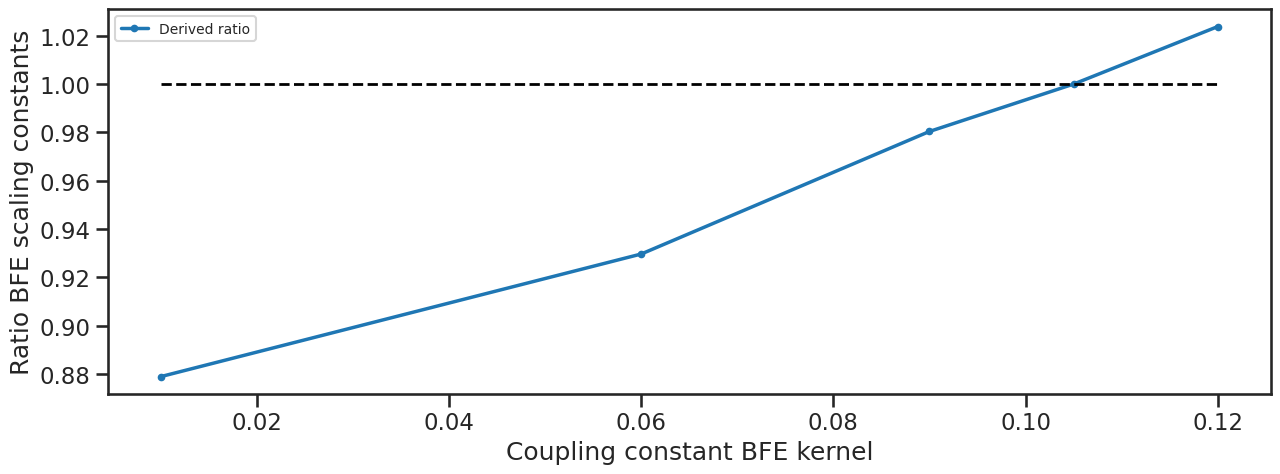

In [44]:
fig, axes = plt.subplots(1,1, figsize=(15,5.0))
axes.plot(alpha_bfe, bfe_kernel_scaling_pid1464/bfe_kernel_scaling_trapist1, '.-', label='Derived ratio')
axes.plot(alpha_bfe, [1]*5, '--', color='black', lw=2)
axes.set_ylabel('Ratio BFE scaling constants')
axes.set_xlabel('Coupling constant BFE kernel')
plt.legend(fontsize=10)
plt.show()

So for a coupling contant value of $\alpha=0.105$ we can define a BFE kernel which can be applied to both 12 micron as well as 5 micron data.

The correct BFE kernel for this observation then becomes:

In [45]:
#bfe_kernel_scaling = -0.00016896014
#bfe_kernel = define_bfe_kernel(bfe_kernel_scaling, detector_gain_crds, 0.12, 0.12, 0.0, 0.0, 0.00, 0.00)

bfe_kernel_scaling = -0.000162673 *0.94
bfe_kernel = define_bfe_kernel(bfe_kernel_scaling, detector_gain_crds, 0.105, 0.105, 0.0, 0.0, 0.00, 0.00)

#bfe_kernel_scaling = -0.000157172
#bfe_kernel = define_bfe_kernel(bfe_kernel_scaling, detector_gain_crds, 0.09, 0.09, 0.0, 0.0, 0.00, 0.00)

#bfe_kernel_scaling = -0.000145384
#bfe_kernel = define_bfe_kernel(bfe_kernel_scaling, detector_gain_crds, 0.06, 0.06, 0.0, 0.0, 0.00, 0.00)

#bfe_kernel_scaling = -0.00013123
#bfe_kernel = define_bfe_kernel(bfe_kernel_scaling, detector_gain_crds, 0.01, 0.01, 0.0, 0.00, 0.00, 0.00)

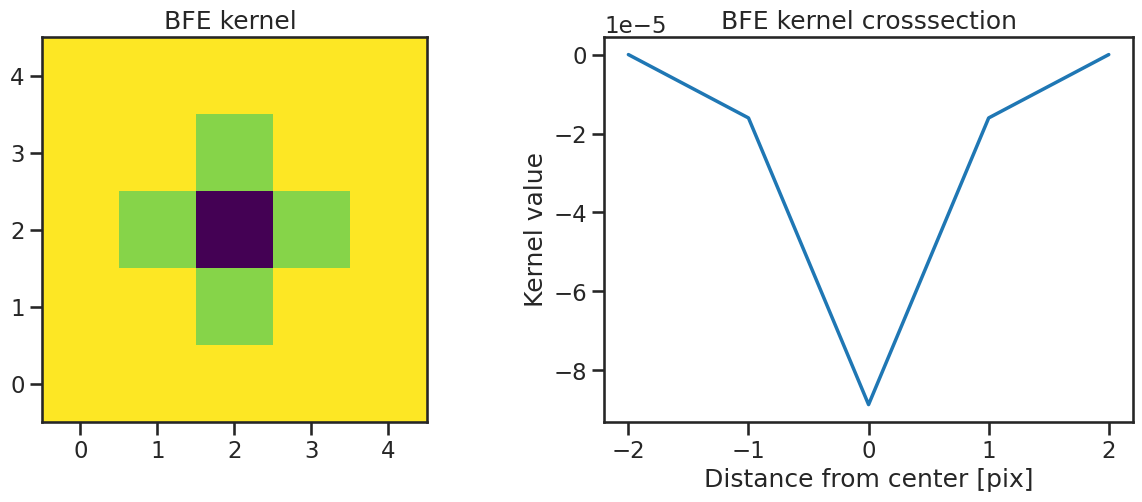

In [46]:
fig, axes = plt.subplots(1,2, figsize=(15,5.0))
axes[0].imshow(bfe_kernel, cmap='viridis', origin='lower', aspect='equal',
                       interpolation='None')
axes[0].set_title('BFE kernel ')
axes[1].plot(np.arange(bfe_kernel.shape[1])-bfe_kernel.shape[1]//2 , bfe_kernel[bfe_kernel.shape[0]//2,:])
axes[1].set_title('BFE kernel crosssection')
axes[1].set_ylabel('Kernel value')
axes[1].set_xlabel('Distance from center [pix]')
plt.show()

Note, that in case one would use a power law shape for the kernel, this would correspond approximately with a power of -3.6.

## Run theDetector 1 pipeline steps  upto the point were the BFE correction should be applied.

In [47]:
nsegments = len(data_files)
miri_data = [None]*nsegments
for i in range(nsegments):
    miri_data[i] = pipe.dq_init.call(data_files[i])
    #miri_data[i] = calwebb_detector1.dq_init_step.DQInitStep.call(data_files[i])

2024-08-29 13:29:23,755 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2024-08-29 13:29:23,938 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (PosixPath('/mnt/beegfs/krause/miri_comm/miri_linearity/data/PID1464/uncal/jw01464005001_02101_00001_mirimage_uncal.fits'),).
2024-08-29 13:29:23,940 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2024-08-29 13:29:30,788 - stpipe.DQInitStep - INFO - Using MASK reference file /mnt/beegfs/krause/miri_comm/crds_cache/references/jwst/miri/jwst_miri_mask_0036.fits
2024-08-29 13:29:30,870 - stpipe.DQInitStep - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-08-29 13:29:30,886 - stpipe.DQInitStep - WARNING - Keyword UNRELIABLE_R

In [48]:
for i in range(nsegments):
    miri_data[i] = pipe.emicorr.call(miri_data[i])
    #miri_data[i] = calwebb_detector1.emicorr_step.EmiCorrStep.call(miri_data[i])

2024-08-29 13:29:34,962 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /mnt/beegfs/krause/miri_comm/crds_cache/references/jwst/miri/jwst_miri_pars-emicorrstep_0002.asdf
2024-08-29 13:29:34,976 - stpipe.EmiCorrStep - INFO - EmiCorrStep instance created.
2024-08-29 13:29:35,161 - stpipe.EmiCorrStep - INFO - Step EmiCorrStep running with args (<RampModel(2, 125, 1024, 1032) from jw01464005001_02101_00001_mirimage_uncal.fits>,).
2024-08-29 13:29:35,163 - stpipe.EmiCorrStep - INFO - Step EmiCorrStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_intermediate_results: False
  user_supplied_reffile: None
  nints_to_phase: None
  nbins: None
  scale_reference: True
  onthefly_corr_freq: None
  use_n_cycles: 3
2024-08-29 13:29:35,183 - stpipe.EmiCorrStep - INFO - Using CRDS refer

In [49]:
for i in range(nsegments):
    miri_data[i] =  pipe.saturation.call(miri_data[i])
#    #miri_data[i] = calwebb_detector1.saturation_step.SaturationStep.call(miri_data[i])

2024-08-29 13:31:34,010 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2024-08-29 13:31:34,332 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(2, 125, 1024, 1032) from jw01464005001_02101_00001_mirimage_uncal.fits>,).
2024-08-29 13:31:34,334 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  n_pix_grow_sat: 1
2024-08-29 13:31:34,357 - stpipe.SaturationStep - INFO - Using SATURATION reference file /mnt/beegfs/krause/miri_comm/crds_cache/references/jwst/miri/jwst_miri_saturation_0034.fits
2024-08-29 13:31:34,478 - stpipe.SaturationStep - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-08-29 13:31:34,493 - stpipe.SaturationStep - W

In [50]:
for i in range(nsegments):
    miri_data[i] = pipe.firstframe.call(miri_data[i])
    miri_data[i] = pipe.lastframe.call(miri_data[i])

2024-08-29 13:31:51,670 - stpipe.FirstFrameStep - INFO - FirstFrameStep instance created.
2024-08-29 13:31:51,982 - stpipe.FirstFrameStep - INFO - Step FirstFrameStep running with args (<RampModel(2, 125, 1024, 1032) from jw01464005001_02101_00001_mirimage_uncal.fits>,).
2024-08-29 13:31:51,984 - stpipe.FirstFrameStep - INFO - Step FirstFrameStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2024-08-29 13:31:52,913 - stpipe.FirstFrameStep - INFO - Step FirstFrameStep done
2024-08-29 13:31:52,932 - stpipe.LastFrameStep - INFO - LastFrameStep instance created.
2024-08-29 13:31:53,087 - stpipe.LastFrameStep - INFO - Step LastFrameStep running with args (<RampModel(2, 125, 1024, 1032) from jw01464005001_02101_00001_mirimage_uncal.fits>,).
2024-08-29 13:31:53,089 - stpipe.LastFrameStep -

In [51]:
# for i in range(nsegments):
#     miri_data[i] = pipe.linearity.call(miri_data[i])

In [52]:
#for i in range(nsegments):
#    miri_data[i] = pipe.ipc.call(miri_data[i])

### Check the contents of the data from the pipeline

In [53]:
miri_data[0].info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.15.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 9230d37c36bcf6affb75b58b216c159c03cd6b533cc9937793064300878b8937
├─data (ndarray): shape=(2, 125, 1024, 1032), dtype=float32
├─group (FITS_rec): shape=(125,), dtype=void800
├─int_times (FITS_rec): shape=(2,), dtype=void416
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─bunit_data (str): DN
│ ├─compress (bool): False
│ ├─coordinates (dict) ...
│ └─32 not shown
├─refout (ndarray): shape=(2, 125, 256, 1032), dtype=float32
├─extra_fits (dict) ...
├─pixeldq (ndarray): shape=(1024, 1032), dtype=uint32
├─groupdq (ndarray): shape=(2, 125, 1024, 1032), dtype=uint8
└─err (ndarray): shape=(2, 125, 1024, 1032), dtype=float32
Some nodes not shown.


## Combine all data and masks into masked array

In [54]:
ramp_cube = np.ma.masked_invalid(miri_data[0].data.astype(float))[:, :, :, 4:-4]
for i in range(1, len(miri_data)):
    ramp_cube = np.ma.vstack([ramp_cube, np.ma.masked_invalid(miri_data[i].data.astype(float))[:, :, :, 4:-4]])

nints = ramp_cube.shape[0]
nframes = ramp_cube.shape[1]

bits_not_to_flag= list(np.arange(2, 27, dtype=int))
groupdq = create_mask_from_dq(miri_data[0].groupdq, bits_not_to_flag=bits_not_to_flag)[:, :, :, 4:-4]
pixel_dq = create_mask_from_dq(miri_data[0].pixeldq.astype(int), bits_not_to_flag=bits_not_to_flag)[:,4:-4]
pixel_dq = np.tile(pixel_dq, (groupdq.shape[0], groupdq.shape[1], 1, 1))
for i in range(1, len(miri_data)):
    groupdq_temp = create_mask_from_dq(miri_data[i].groupdq, bits_not_to_flag=bits_not_to_flag)[:, :, :, 4:-4]
    groupdq = np.vstack([groupdq, groupdq_temp])
    pixel_dq_temp = create_mask_from_dq(miri_data[i].pixeldq.astype(int), bits_not_to_flag=bits_not_to_flag)[:,4:-4]
    pixel_dq_temp = np.tile(pixel_dq_temp, (groupdq_temp.shape[0], groupdq_temp.shape[1], 1, 1))
    pixel_dq = np.vstack([pixel_dq, pixel_dq_temp])

ramp_cube.mask = ramp_cube.mask |  groupdq | pixel_dq

ramp_image = np.ma.median(ramp_cube, axis=0)

In [55]:
print(f'Number of integrations: {nints}, number of frames: {nframes}')

Number of integrations: 2, number of frames: 125


# Linearization of the detector ramps

In the following we will test the effect of ramp non-linearities and their mittigation. 

First we apply the current standard linearity step, that the linearity correction including the BFE correction and a CRDS correction per integration. Then we try a BFE correction determined from the median data set and apply that to all integrations. 

### estimate of the saturation values after applying linearity correction and ipc

Only used for stability in the BFE correction code.

In [56]:
soft_saturation = linearity_correction(ipc_correction(saturation_data_model.data[:, 4:-4], ipc_kernel), lin_coeffs)

In [57]:
hard_saturation = linearity_correction(ipc_correction(np.ones((soft_saturation.shape))*2**16., ipc_kernel), lin_coeffs)

### Standard ramp linearization and dark subtraction

In [58]:
darks_use = ipc_correction(imager_darks, ipc_kernel)
standard_linearized_data_cube_orig = ramp_cube.copy()
standard_linearized_data_cube = ipc_correction(standard_linearized_data_cube_orig, ipc_kernel)
standard_linearized_data_cube = linearity_correction(standard_linearized_data_cube, lin_coeffs)
standard_linearized_data_cube = dark_correction(standard_linearized_data_cube, darks_use)

2024-08-29 13:33:22,315 - stpipe - WARNING - nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.


In [59]:
standard_linearized_ramp_image = np.ma.median(standard_linearized_data_cube, axis=0)

### Linearization per integration including BFE correction

In [60]:
linearized_data_cube = linearity_correction(ramp_cube, lin_coeffs)
linearized_data_cube = ipc_correction(linearized_data_cube, ipc_kernel)

In [64]:
linearized_data_cube, bfe_correction_data_cube = \
    bfe_correction(linearized_data_cube, bfe_kernel, sobel_kernel, correction_difference_limit_bfe,
                   detector_gain_image_crds, max_iterations=15, verbose=False)

  0%|          | 0/2 [00:00<?, ?it/s]

In [65]:
darks_use = ipc_correction(imager_darks, ipc_kernel)

linearized_data_cube = dark_correction(linearized_data_cube, darks_use)
linearized_data_cube, _, _, _ =\
    rscd_correction(linearized_data_cube, time_constant_rscd, rscd_constant, detector_gain_image_crds)

In [66]:
linearized_ramp_image = np.ma.median(linearized_data_cube, axis=0)

### Linearization including BFE based on time avaraged data. 

This is faster than determining the linearization per integration. For a stable pointed source this might be good enough. 

In [67]:
linearized_data_cube_time_av_orig = ramp_cube.copy()
linearized_data_cube_time_av = linearity_correction(linearized_data_cube_time_av_orig, lin_coeffs)
linearized_data_cube_time_av = ipc_correction(linearized_data_cube_time_av, ipc_kernel)

In [68]:
time_average_signal = np.ma.median(linearized_data_cube_time_av, axis=0)

In [69]:
time_averaged_bfe_corrected_signal, bfe_correction_data_cube_time_av = \
    bfe_correction(time_average_signal[None, ...], bfe_kernel, sobel_kernel, correction_difference_limit_bfe ,detector_gain_image_crds,
                   max_iterations=15, verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Working on integration 0
Iteration :0, Convergence criteria: 10.0
Iteration :1, Convergence criteria: 10.0


In [70]:
darks_use = ipc_correction(imager_darks, ipc_kernel)
linearized_data_cube_time_av = linearized_data_cube_time_av + np.tile(bfe_correction_data_cube_time_av, (nints, 1, 1, 1))
linearized_data_cube_time_av = dark_correction(linearized_data_cube_time_av, darks_use)
linearized_data_cube_time_av, rscd_ramp_correction_time_av, max_signal_rscd_corr_time_av, scaling_rscd_corr_time_av =\
    rscd_correction(linearized_data_cube_time_av, time_constant_rscd, rscd_constant, detector_gain_image_crds)

In [75]:
linearized_ramp_image_time_av_corr = np.ma.median(linearized_data_cube_time_av, axis=0)

## Analysis of the Point Source Data.

We now look at the effect the different linearizations have on the  point source data

#### Select the target region

In [76]:
#target_slice = (slice(1,nframes-75), slice(907-17,907+17), slice(573-17-4,573+17-4))
#target_slice_cube = (slice(None), slice(1,nframes-75), slice(907-17,907+17), slice(573-17-4,573+17-4))


target_slice = (slice(1,nframes-1-4), slice(688-17,688+17), slice(706-17-1,706+17-1))
target_slice_cube = (slice(None), slice(1,nframes-1-4), slice(688-17,688+17), slice(706-17-1,706+17-1))

In [77]:
print(f'Starting amplifier: {((706-17-1) % 4)}')

Starting amplifier: 0


In [78]:
target_ramp_image = ramp_image[target_slice].copy()
target_standard_linearized_ramp_image = standard_linearized_ramp_image[target_slice].copy()
target_ramp_image_lin = linearized_ramp_image[target_slice].copy()
target_ramp_image_lin_time_av_corr = linearized_ramp_image_time_av_corr[target_slice].copy()

In [79]:
max_indx = np.unravel_index(np.ma.argmax(target_ramp_image[-1, ...], axis=None), target_ramp_image[-1, ...].shape)
print(f'Maximum at: {max_indx}')

Maximum at: (17, 18)


#### Shift the Webbpsf model to the exact source position

In [80]:
from scipy.ndimage import fourier_shift
#shift = (0.82, -0.14)
shift = (0.66, 1.70)
#scaling = 1.15e4
scaling = 4.15e3
# The shift corresponds to the pixel offset relative to the reference image
offset_psf_image = fourier_shift(np.fft.fftn(model_psf[3].data*scaling + 7), shift)
offset_psf_image = np.fft.ifftn(offset_psf_image).real

#### Plot the non linearized data and the different linearized data sets

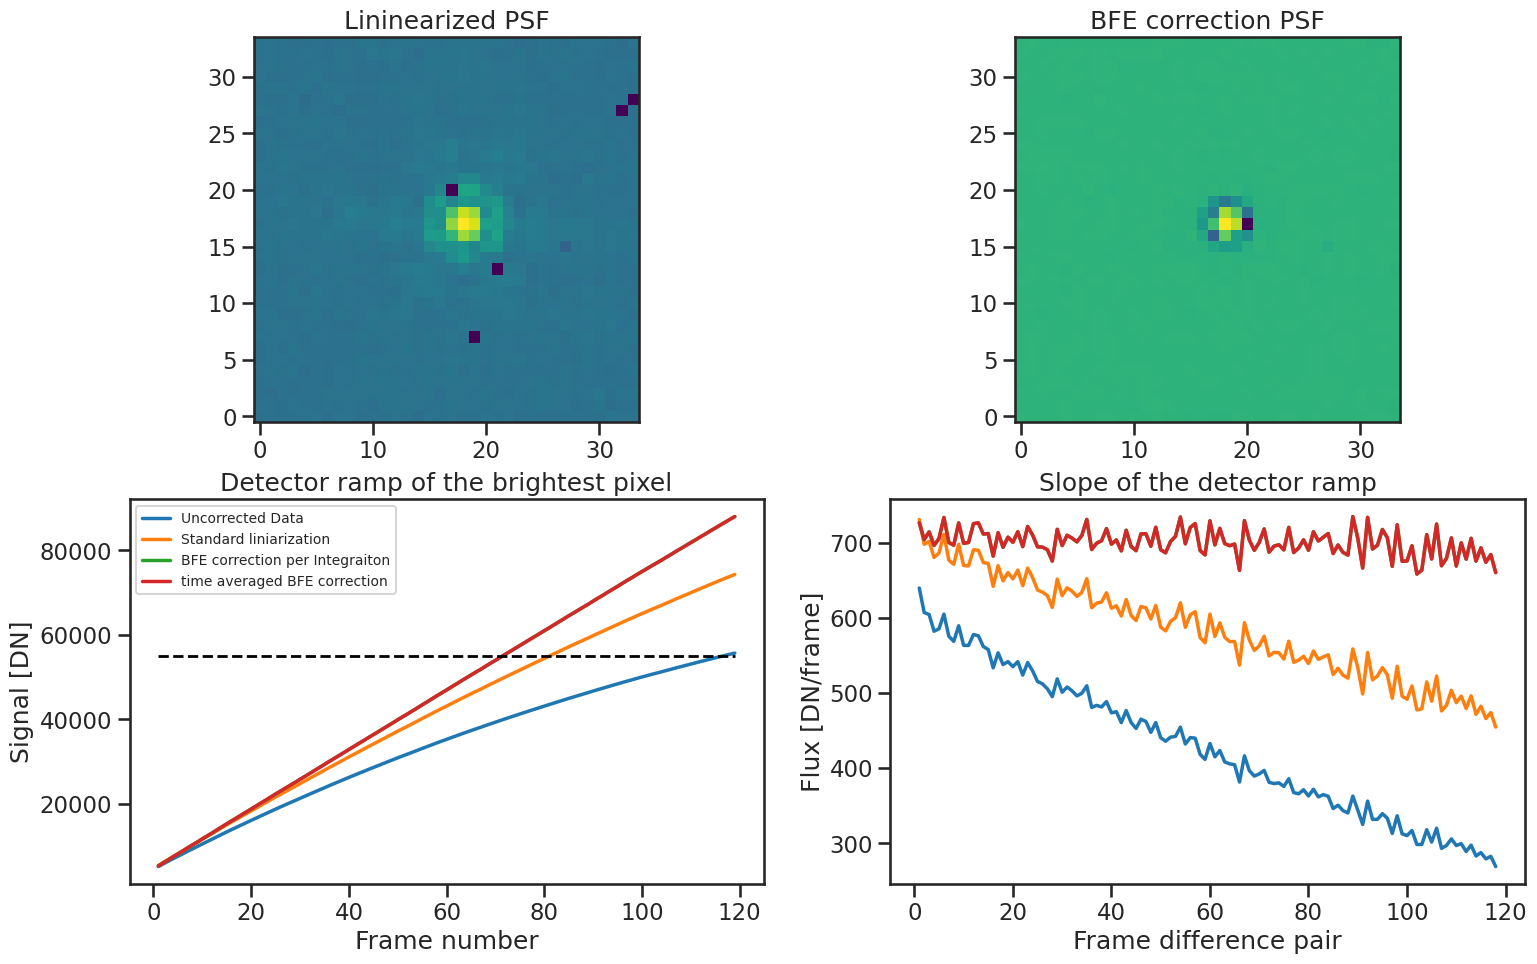

In [81]:
fig, axes = plt.subplots(2,2, figsize=(18,11))

im1 = np.ma.median(np.ma.diff(target_ramp_image_lin[:, ...], axis=0), axis=0).filled(0)
interval = MinMaxInterval()
vmin, vmax = interval.get_limits(im1)
stretch = LogStretch()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)
axes[0, 0].imshow(im1,  cmap='viridis', origin='lower', norm=norm,
                       interpolation='None')
axes[0, 0].set_title('Lininearized PSF')

im2 = np.ma.median(np.ma.diff(target_ramp_image[:, ...], axis=0), axis=0).filled(0)
interval = MinMaxInterval()
vmin, vmax = interval.get_limits(im1-im2)
stretch = LogStretch()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)
axes[0, 1].imshow(im1 - im2,  cmap='viridis', origin='lower', norm=norm,
                       interpolation='None')
axes[0, 1].set_title('BFE correction PSF')

#nframes_max = 69+5
nframes_max = 4
axes[1, 0].plot(np.arange(nframes-2-nframes_max)+1, target_ramp_image[(slice(None), *max_indx)], label='Uncorrected Data')
axes[1, 0].plot(np.arange(nframes-2-nframes_max)+1, target_standard_linearized_ramp_image[(slice(None), *max_indx)], label='Standard liniarization')
axes[1, 0].plot(np.arange(nframes-2-nframes_max)+1, target_ramp_image_lin[(slice(None), *max_indx)], label='BFE correction per Integraiton')
axes[1, 0].plot(np.arange(nframes-2-nframes_max)+1, target_ramp_image_lin_time_av_corr[(slice(None), *max_indx)], label='time averaged BFE correction')
axes[1, 0].plot([1, nframes-2-nframes_max],[5.5e4, 5.5e4], '--', color='black', lw=2)
axes[1, 0].set_title('Detector ramp of the brightest pixel')
axes[1, 0].set_ylabel('Signal [DN]')
axes[1, 0].set_xlabel('Frame number')
axes[1, 0].legend(fontsize=10)

axes[1, 1].plot(np.arange(nframes-3-nframes_max)+1,np.ma.diff(target_ramp_image, axis=0)[(slice(None), max_indx[0], max_indx[1])])
axes[1, 1].plot(np.arange(nframes-3-nframes_max)+1,np.ma.diff(target_standard_linearized_ramp_image, axis=0)[(slice(None), max_indx[0], max_indx[1])])
axes[1, 1].plot(np.arange(nframes-3-nframes_max)+1,np.ma.diff(target_ramp_image_lin, axis=0)[(slice(None), max_indx[0], max_indx[1])])
axes[1, 1].plot(np.arange(nframes-3-nframes_max)+1,np.ma.diff(target_ramp_image_lin_time_av_corr, axis=0)[(slice(None), max_indx[0], max_indx[1])])
axes[1, 1].set_title('Slope of the detector ramp')
axes[1, 1].set_ylabel('Flux [DN/frame]')
axes[1, 1].set_xlabel('Frame difference pair')

plt.show()

As one can see from the above figures are the ramps after applying the BFE correction almost perfectly linear, this in contrast to the uncorrected ramps or after applying the standard linearization correction. For this aprticular data set, there is no significant difference between the BFE correction per integration or deriving a BFE correction from a time averaged data set. As the pointing is absolutely stable, and we are using the integrations toward the end of the time series, where any responce drifts are stabelized, this is not an unexpected result.

Below, we explore the effect of the different linearizations on the PSF in more detail. For this we plot the crossections through the brightest pixel of the PSF along the row and columns going up the ramp. For comparison, we also plot the WebbPSF model.

RMS y-cut no lin.corr.      :   1188450.99
RMS x-cut no lin.corr.      :   1280429.26
RMS y-cut standard lin.corr.:    593692.19
RMS x-cut standard lin.corr.:    638211.60
RMS y-cut with BFE corr.    :    108743.93
RMS x-cut with BFE corr.    :    124194.37
RMS y-cut time av. BFE corr.:    108768.51
RMS x-cut time av. BFE corr.:    124207.25


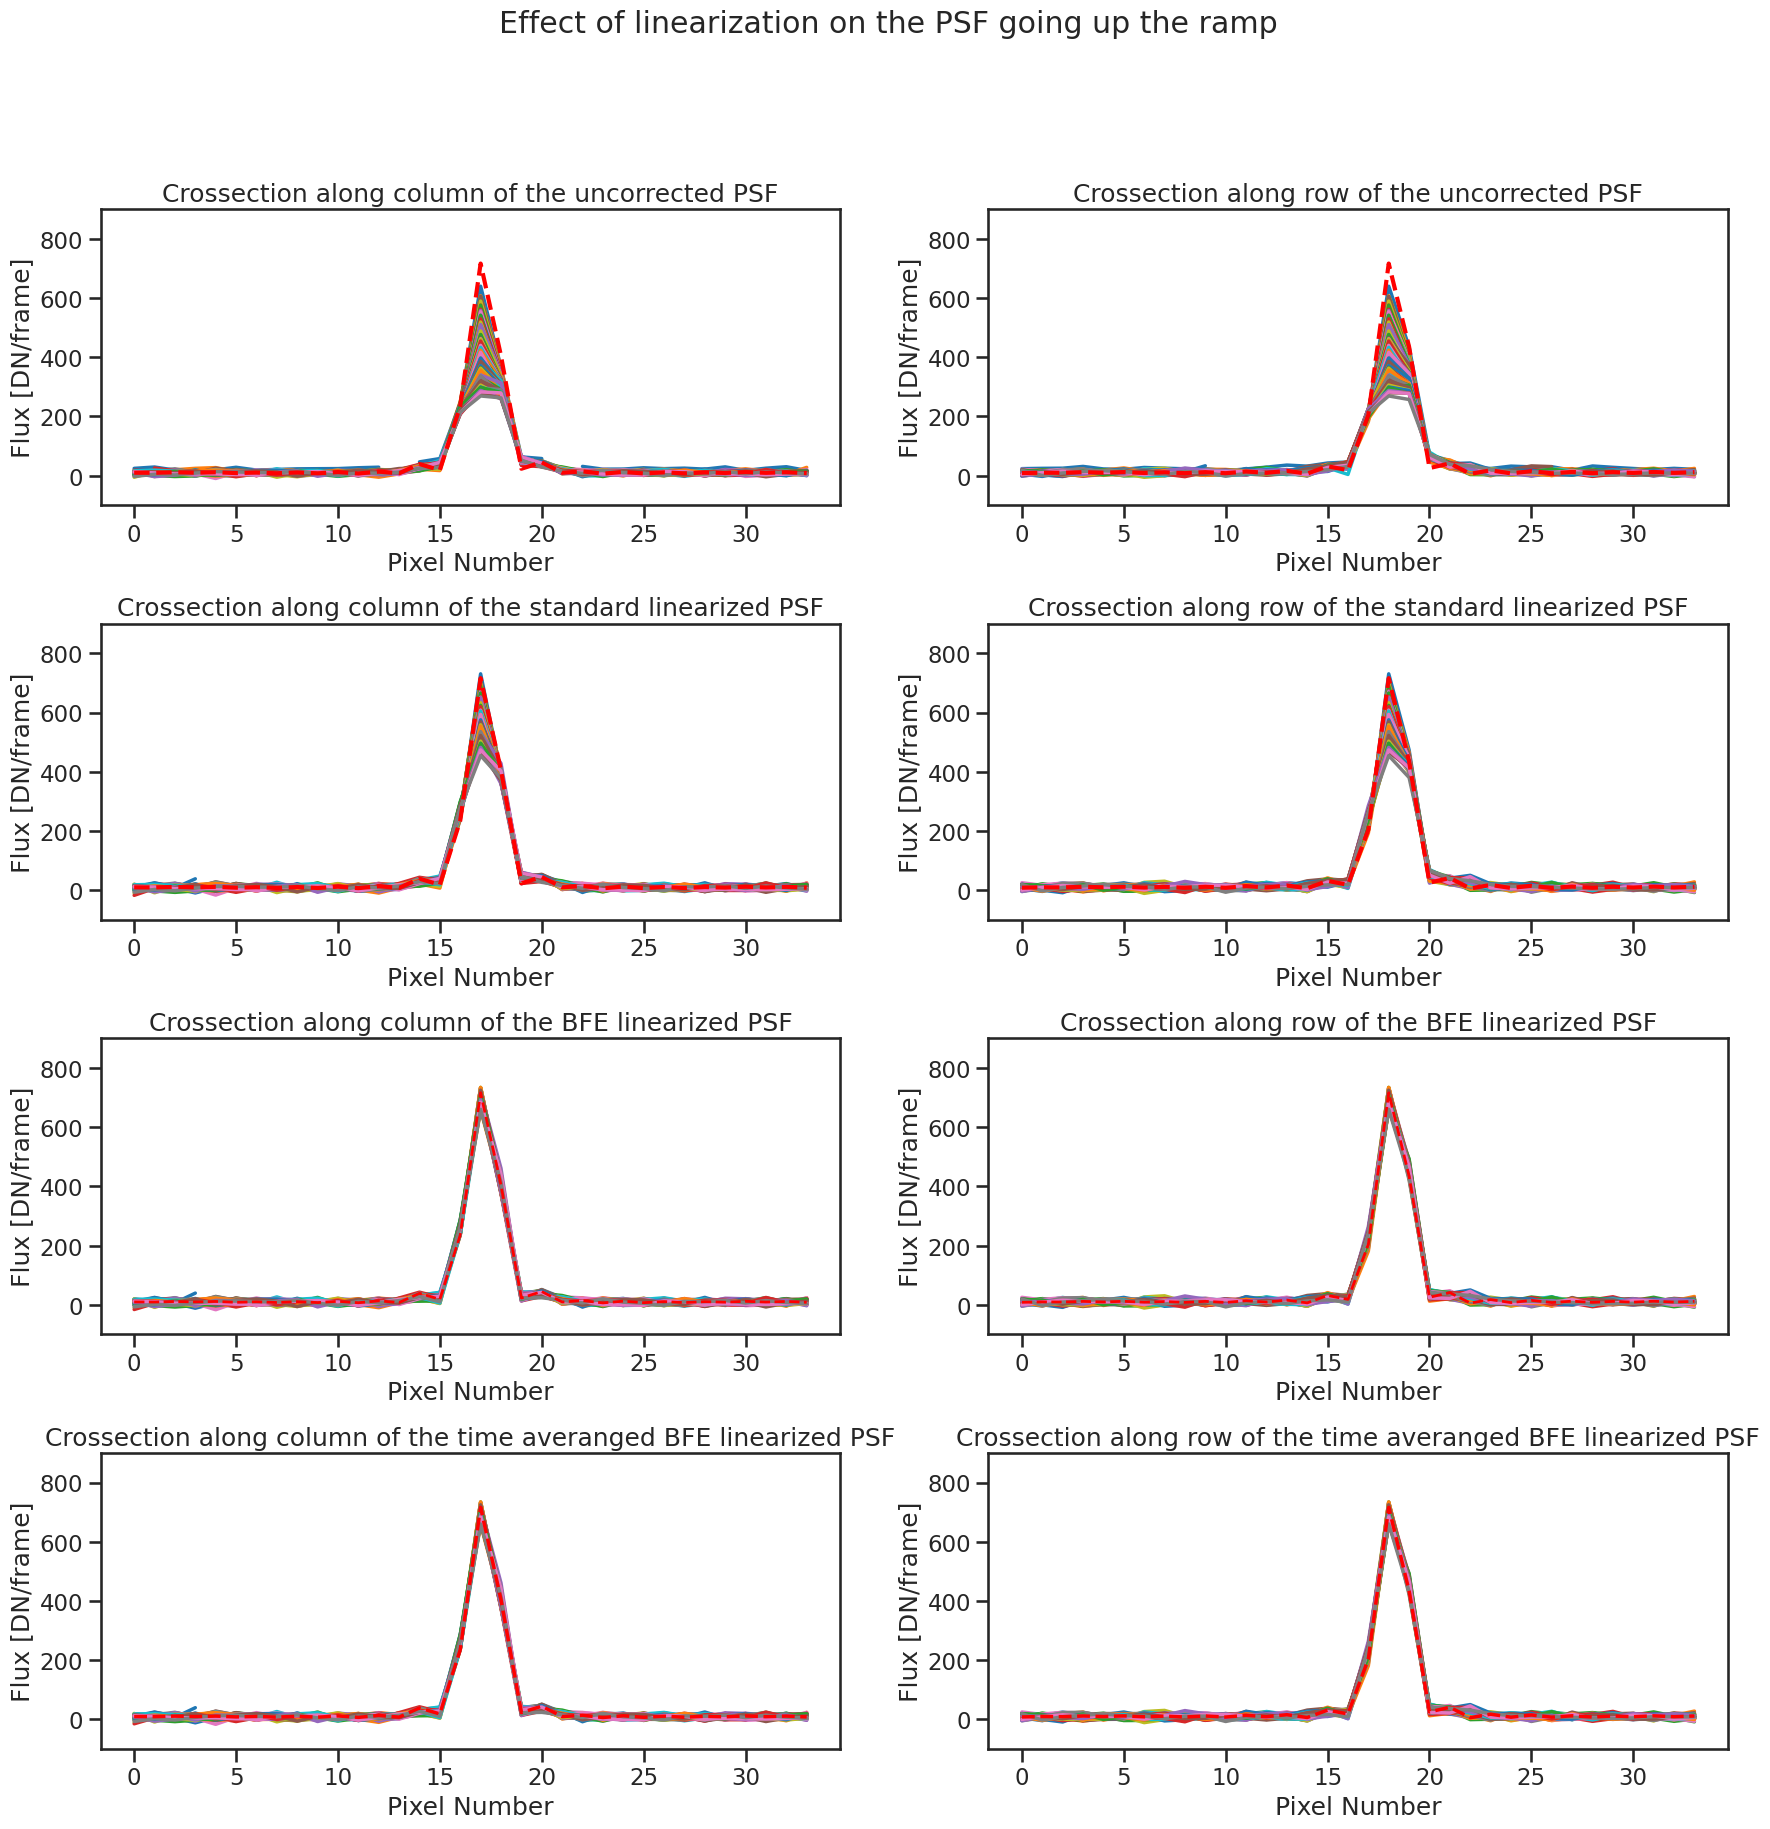

In [82]:
fig, axes = plt.subplots(4,2, figsize=(21,20))

flux_y = np.ma.diff(target_ramp_image[(slice(None), slice(None), max_indx[1])], axis=0)
flux_y = sigma_clip(flux_y, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
flux_x = np.ma.diff(target_ramp_image[(slice(None), max_indx[0], slice(None))], axis=0)
flux_x = sigma_clip(flux_x, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
print(f'RMS y-cut no lin.corr.      : {np.ma.sum((flux_y - np.ma.mean(flux_y, axis=0))[:,max_indx[0]-5:max_indx[0]+6]**2) :>12.2f}')
print(f'RMS x-cut no lin.corr.      : {np.ma.sum((flux_x - np.ma.mean(flux_x, axis=0))[:,max_indx[1]-5:max_indx[1]+6]**2) :>12.2f}')
axes[0, 0].plot(flux_y.T)
axes[0, 0].plot(offset_psf_image[(slice(None), max_indx[1])].T, '--', color='red', lw=3)
axes[0, 1].plot(flux_x.T)
axes[0, 1].plot(offset_psf_image[(max_indx[0], slice(None))].T, '--', color='red', lw=3)
axes[0, 0].set_ylim([-100, 900])
axes[0, 1].set_ylim([-100, 900])
axes[0, 0].set_title('Crossection along column of the uncorrected PSF')
axes[0, 1].set_title('Crossection along row of the uncorrected PSF')
axes[0, 0].set_ylabel('Flux [DN/frame]')
axes[0, 1].set_ylabel('Flux [DN/frame]')
axes[0, 0].set_xlabel('Pixel Number')
axes[0, 1].set_xlabel('Pixel Number')

flux_y = np.ma.diff(target_standard_linearized_ramp_image[(slice(None), slice(None), max_indx[1])], axis=0)
flux_y = sigma_clip(flux_y, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
flux_x = np.ma.diff(target_standard_linearized_ramp_image[(slice(None), max_indx[0], slice(None))], axis=0)
flux_x = sigma_clip(flux_x, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
print(f'RMS y-cut standard lin.corr.: {np.ma.sum((flux_y - np.ma.mean(flux_y, axis=0))[:,max_indx[0]-5:max_indx[0]+6]**2) :>12.2f}')
print(f'RMS x-cut standard lin.corr.: {np.ma.sum((flux_x - np.ma.mean(flux_x, axis=0))[:,max_indx[1]-5:max_indx[1]+6]**2) :>12.2f}')
axes[1, 0].plot(flux_y.T)
axes[1, 0].plot(offset_psf_image[(slice(None), max_indx[1])].T, '--', color='red', lw=3)
axes[1, 1].plot(flux_x.T)
axes[1, 1].plot(offset_psf_image[(max_indx[0], slice(None))].T, '--', color='red', lw=3)
axes[1, 0].set_ylim([-100, 900])
axes[1, 1].set_ylim([-100, 900])
axes[1, 0].set_title('Crossection along column of the standard linearized PSF')
axes[1, 1].set_title('Crossection along row of the standard linearized PSF')
axes[1, 0].set_ylabel('Flux [DN/frame]')
axes[1, 1].set_ylabel('Flux [DN/frame]')
axes[1, 0].set_xlabel('Pixel Number')
axes[1, 1].set_xlabel('Pixel Number')

flux_y = np.ma.diff(target_ramp_image_lin[(slice(None), slice(None), max_indx[1])], axis=0)
flux_y = sigma_clip(flux_y, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
flux_x = np.ma.diff(target_ramp_image_lin[(slice(None), max_indx[0], slice(None))], axis=0)
flux_x = sigma_clip(flux_x, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
print(f'RMS y-cut with BFE corr.    : {np.ma.sum((flux_y - np.ma.mean(flux_y, axis=0))[:,max_indx[0]-5:max_indx[0]+6]**2) :>12.2f}')
print(f'RMS x-cut with BFE corr.    : {np.ma.sum((flux_x - np.ma.mean(flux_x, axis=0))[:,max_indx[1]-5:max_indx[1]+6]**2) :>12.2f}')
axes[2, 0].plot(flux_y.T)
axes[2, 0].plot(offset_psf_image[(slice(None), max_indx[1])].T, '--', color='red', lw=2)
axes[2, 1].plot(flux_x.T)
axes[2, 1].plot(offset_psf_image[(max_indx[0], slice(None))].T, '--', color='red', lw=2)
axes[2, 0].set_ylim([-100, 900])
axes[2, 1].set_ylim([-100, 900])
axes[2, 0].set_title('Crossection along column of the BFE linearized PSF')
axes[2, 1].set_title('Crossection along row of the BFE linearized PSF')
axes[2, 0].set_ylabel('Flux [DN/frame]')
axes[2, 1].set_ylabel('Flux [DN/frame]')
axes[2, 0].set_xlabel('Pixel Number')
axes[2, 1].set_xlabel('Pixel Number')

flux_y = np.ma.diff(target_ramp_image_lin_time_av_corr[(slice(None), slice(None), max_indx[1])], axis=0)
flux_y = sigma_clip(flux_y, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
flux_x = np.ma.diff(target_ramp_image_lin_time_av_corr[(slice(None), max_indx[0], slice(None))], axis=0)
flux_x = sigma_clip(flux_x, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
print(f'RMS y-cut time av. BFE corr.: {np.ma.sum((flux_y - np.ma.mean(flux_y, axis=0))[:,max_indx[0]-5:max_indx[0]+6]**2) :>12.2f}')
print(f'RMS x-cut time av. BFE corr.: {np.ma.sum((flux_x - np.ma.mean(flux_x, axis=0))[:,max_indx[1]-5:max_indx[1]+6]**2) :>12.2f}')
axes[3, 0].plot(flux_y.T)
axes[3, 0].plot(offset_psf_image[(slice(None), max_indx[1])].T, '--', color='red')
axes[3, 1].plot(flux_x.T)
axes[3, 1].plot(offset_psf_image[(max_indx[0], slice(None))].T, '--', color='red')
axes[3, 0].set_ylim([-100, 900])
axes[3, 1].set_ylim([-100, 900])
axes[3, 0].set_title('Crossection along column of the time averanged BFE linearized PSF')
axes[3, 1].set_title('Crossection along row of the time averanged BFE linearized PSF')
axes[3, 0].set_ylabel('Flux [DN/frame]')
axes[3, 1].set_ylabel('Flux [DN/frame]')
axes[3, 0].set_xlabel('Pixel Number')
axes[3, 1].set_xlabel('Pixel Number')

fig.subplots_adjust(hspace=0.4)

fig.suptitle('Effect of linearization on the PSF going up the ramp')

plt.show()

Again, we see that the BFE correction provides a excelent linearization of the detector ramps, resulting in a close match to the observed PSF and the WebbPSF model. Below we plot the difference between the webbPSF model and the linearized data.

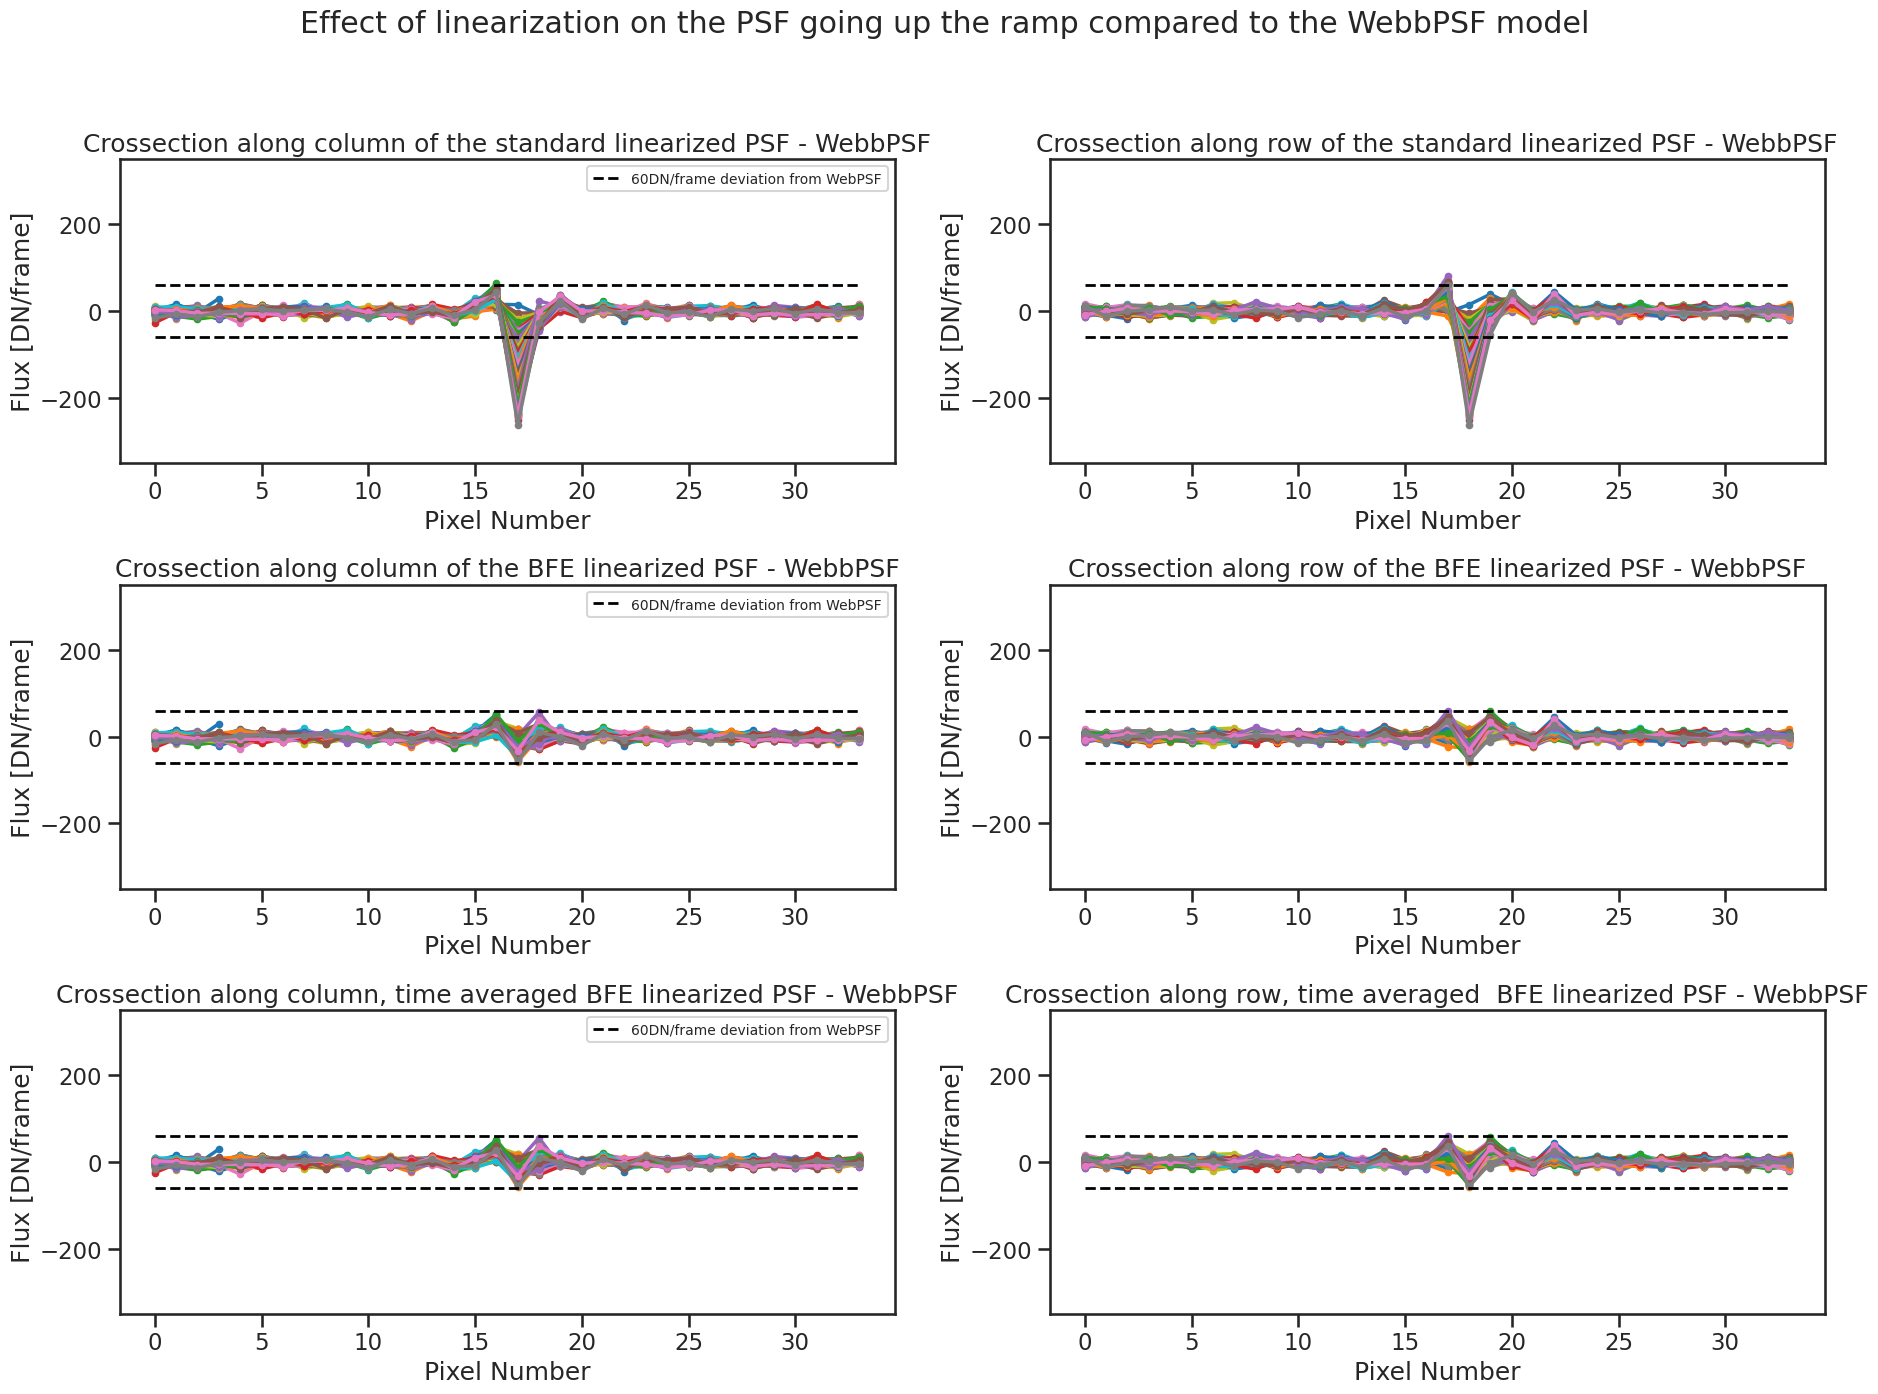

In [147]:
fig, axes = plt.subplots(3,2, figsize=(22,15))

flux_diff_y = (np.ma.diff(target_standard_linearized_ramp_image[(slice(None), slice(None), max_indx[1])], axis=0) - 
                offset_psf_image[(slice(None), max_indx[1])])
flux_diff_y = sigma_clip(flux_diff_y, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
flux_diff_x = (np.ma.diff(target_standard_linearized_ramp_image[(slice(None),  max_indx[0], slice(None))], axis=0) -
               offset_psf_image[( max_indx[0], slice(None))])
flux_diff_x = sigma_clip(flux_diff_x, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
axes[0, 0].plot(flux_diff_y.T,    '.-')
axes[0, 1].plot(flux_diff_x.T,   '.-')
axes[0, 0].set_title('Crossection along column of the standard linearized PSF - WebbPSF')
axes[0, 1].set_title('Crossection along row of the standard linearized PSF - WebbPSF')
axes[0, 0].set_ylabel('Flux [DN/frame]')
axes[0, 1].set_ylabel('Flux [DN/frame]')
axes[0, 0].set_xlabel('Pixel Number')
axes[0, 1].set_xlabel('Pixel Number')
axes[0, 0].set_ylim([-350, 350])
axes[0, 1].set_ylim([-350, 350])

axes[0, 0].plot([0, 33], [60]*2, '--', color='black', lw=2, label='60DN/frame deviation from WebPSF')
axes[0, 0].plot([0, 33], [-60]*2, '--', color='black', lw=2)
axes[0, 1].plot([0, 33], [60]*2, '--', color='black', lw=2, label='60DN/frame deviation from WebPSF')
axes[0, 1].plot([0, 33], [-60]*2, '--', color='black', lw=2)
axes[0, 0].legend(fontsize=10)

flux_diff_y = (np.ma.diff(target_ramp_image_lin[(slice(None), slice(None), max_indx[1])], axis=0) - 
                offset_psf_image[(slice(None), max_indx[1])])
flux_diff_y = sigma_clip(flux_diff_y, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
flux_diff_x = (np.ma.diff(target_ramp_image_lin[(slice(None),  max_indx[0], slice(None))], axis=0) -
               offset_psf_image[( max_indx[0], slice(None))])
flux_diff_x = sigma_clip(flux_diff_x, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
axes[1, 0].plot(flux_diff_y.T,    '.-')
axes[1, 1].plot(flux_diff_x.T,    '.-')
axes[1, 0].set_title('Crossection along column of the BFE linearized PSF - WebbPSF')
axes[1, 1].set_title('Crossection along row of the BFE linearized PSF - WebbPSF')
axes[1, 0].set_ylabel('Flux [DN/frame]')
axes[1, 1].set_ylabel('Flux [DN/frame]')
axes[1, 0].set_xlabel('Pixel Number')
axes[1, 1].set_xlabel('Pixel Number')
axes[1, 0].set_ylim([-350, 350])
axes[1, 1].set_ylim([-350, 350])

axes[1, 0].plot([0, 33], [60]*2, '--', color='black', lw=2, label='60DN/frame deviation from WebPSF')
axes[1, 0].plot([0, 33], [-60]*2, '--', color='black', lw=2)
axes[1, 1].plot([0, 33], [60]*2, '--', color='black', lw=2, label='60DN/frame deviation from WebPSF')
axes[1, 1].plot([0, 33], [-60]*2, '--', color='black', lw=2)
axes[1, 0].legend(fontsize=10)


flux_diff_y = (np.ma.diff(target_ramp_image_lin_time_av_corr[(slice(None), slice(None), max_indx[1])], axis=0) - 
                offset_psf_image[(slice(None), max_indx[1])])
flux_diff_y = sigma_clip(flux_diff_y, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
flux_diff_x = (np.ma.diff(target_ramp_image_lin_time_av_corr[(slice(None),  max_indx[0], slice(None))], axis=0) -
               offset_psf_image[( max_indx[0], slice(None))])
flux_diff_x = sigma_clip(flux_diff_x, sigma=5.0, axis=0, cenfunc='median', stdfunc='mad_std')
axes[2, 0].plot(flux_diff_y.T,    '.-')
axes[2, 1].plot(flux_diff_x.T,    '.-')
axes[2, 0].set_title('Crossection along column, time averaged BFE linearized PSF - WebbPSF')
axes[2, 1].set_title('Crossection along row, time averaged  BFE linearized PSF - WebbPSF')
axes[2, 0].set_ylabel('Flux [DN/frame]')
axes[2, 1].set_ylabel('Flux [DN/frame]')
axes[2, 0].set_xlabel('Pixel Number')
axes[2, 1].set_xlabel('Pixel Number')
axes[2, 0].set_ylim([-350, 350])
axes[2, 1].set_ylim([-350, 350])

axes[2, 0].plot([0, 33], [60]*2, '--', color='black', lw=2, label='60DN/frame deviation from WebPSF')
axes[2, 0].plot([0, 33], [-60]*2, '--', color='black', lw=2)
axes[2, 1].plot([0, 33], [60]*2, '--', color='black', lw=2, label='60DN/frame deviation from WebPSF')
axes[2, 1].plot([0, 33], [-60]*2, '--', color='black', lw=2)
axes[2, 0].legend(fontsize=10)

fig.subplots_adjust(hspace=0.4)

fig.suptitle('Effect of linearization on the PSF going up the ramp compared to the WebbPSF model')

plt.show()

The above figures again clearly show the big improvement to the linearity of the detector ramps and the psf stability after applying the BFE correction. Though there is no clear change in the psf shape anymore after the BFE correction. one can, however, still see some systematic differences between the WebbPSF model and the obsrved PSF. The observed PSF after all correcitons seems to be slightly broader in the center and slightly narrower in the wings compared to the WebbPSF model. These systematic differences are at the 1 to 1.5% level.

## Plot relative flux change up the ramp per pixel

Another way to visuaize the brighter fatter effect is to plot the relatove flux distrobutoin as a function of increasing signal up the ramp for the pixels centered on a point source.  Following Plazas et al 2018 (PASP 130; equations 4 and 5), we define the relative flux diviation in a pixel as:

\begin{equation}
f_N(k) = \frac{F_k - F_1}{F_\star}
\end{equation}

where $F_k$ is the pixel flux calculated by differencing the $k$th and $(k+1)$th frames and $F_\star$ is the time averaged total flux of the central $7\times7$ pixels of the psf.

First we look at the uncorrected data.

In [84]:
sub_image_size=7
nframe_start = 0
nframe_end = nframes-1
sub_slice_image = (slice(nframe_start, nframe_end), slice(max_indx[0]-sub_image_size//2, max_indx[0]+sub_image_size//2+1),
             slice(max_indx[1]-sub_image_size//2, max_indx[1]+sub_image_size//2+1))
sub_slice = (slice(None), slice(nframe_start, nframe_end), slice(max_indx[0]-sub_image_size//2, max_indx[0]+sub_image_size//2+1),
             slice(max_indx[1]-sub_image_size//2, max_indx[1]+sub_image_size//2+1))

In [85]:
target_sub_cube = ramp_cube[target_slice_cube][sub_slice]

In [86]:
Fk = np.ma.median(np.ma.diff(target_sub_cube, axis=1), axis=0)
F1 = Fk[0:1, ...]
Fstar = np.ma.sum(np.ma.median(target_sub_cube[:,-1,  ...] - target_sub_cube[:, 0, ...], axis=0)  , axis=(-2,-1))/(nframes-nframe_start-1-1)

In [87]:
fN = ((Fk-F1).T/ Fstar).T

In [88]:
Sav = np.ma.median(np.ma.sum(target_sub_cube[:, :-1, ...] + np.ma.diff(target_sub_cube, axis=1)/2.0, axis=(-2,-1)), axis=0)

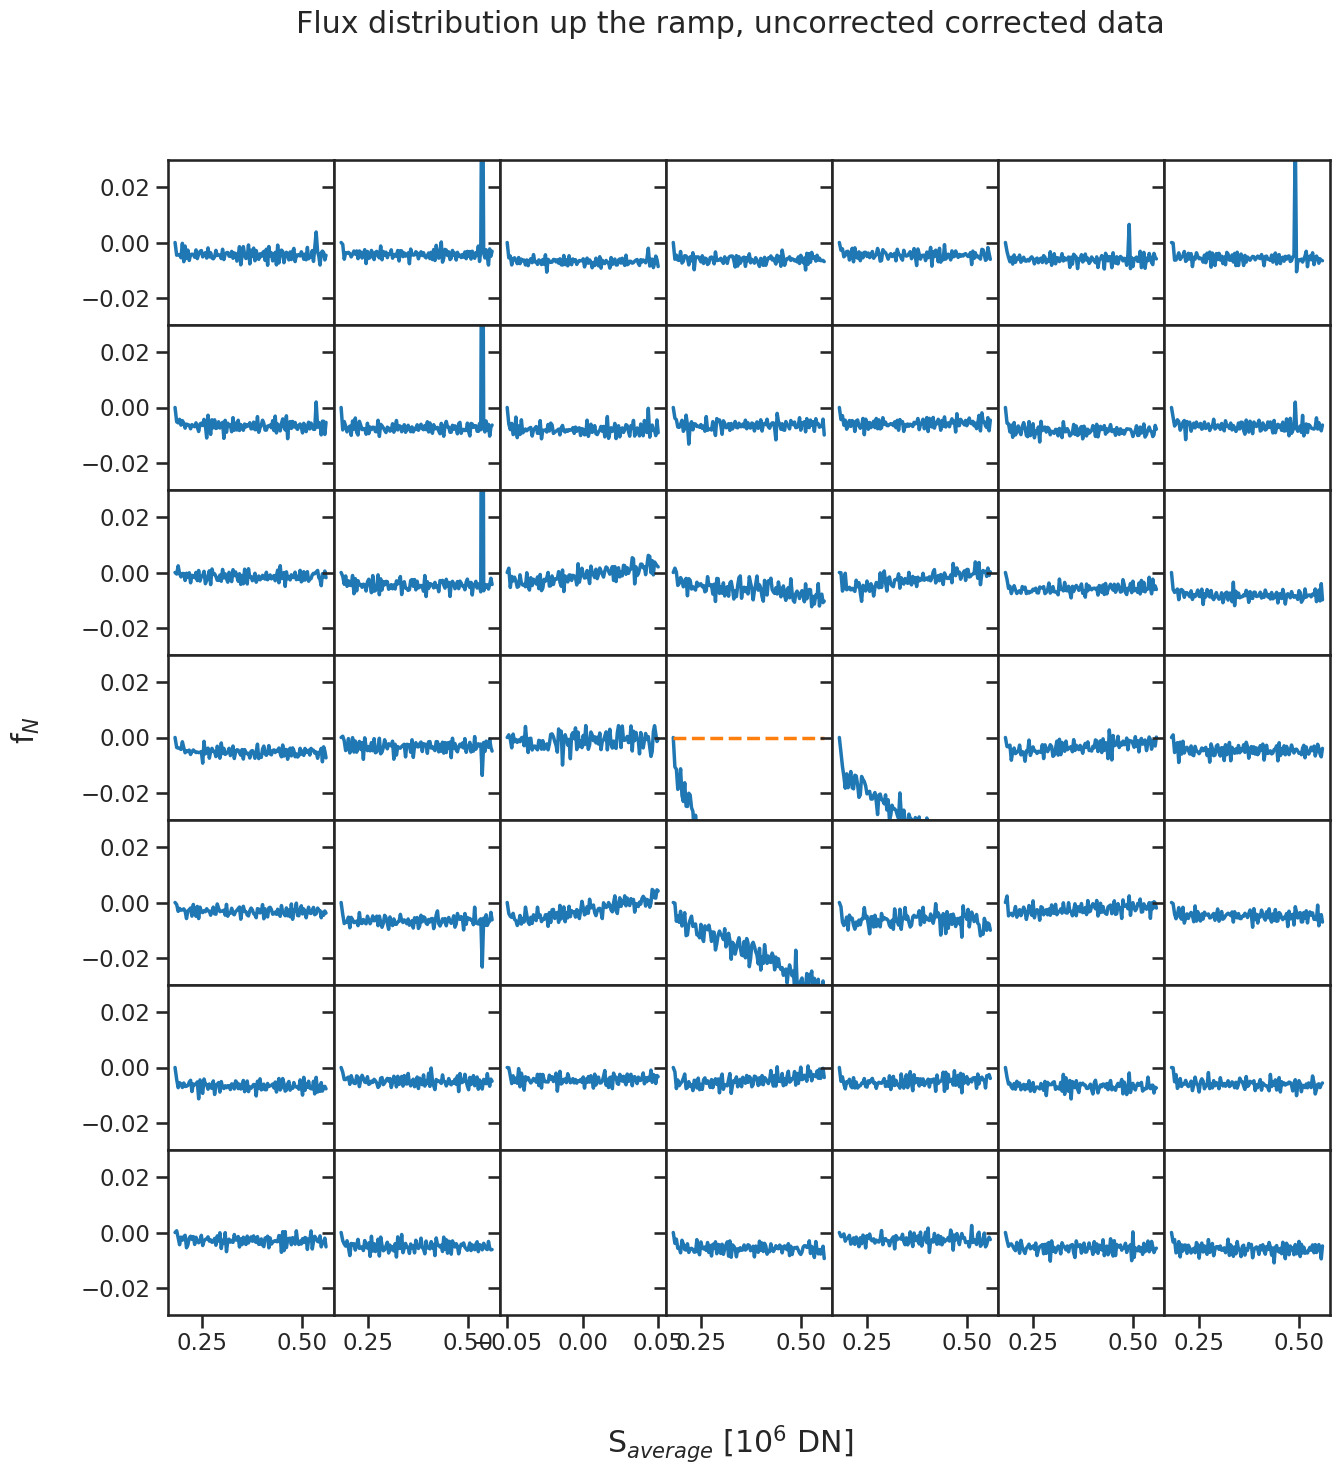

In [89]:
fig, axes = plt.subplots(fN.shape[-2], fN.shape[-1], figsize=(15,15))

for i in range(fN.shape[-2]):
    for j in range(fN.shape[-1]):
        axes[i,j].plot(Sav/1.e6, fN[:, i,j])
        if (j==fN.shape[-2]//2) and (i==fN.shape[-1]//2):
            axes[i,j].plot(Sav/1.e6, Sav*0, '--')
        axes[i,j].set_ylim([-0.0295, 0.0295])
        
        #x_labels = [ 0.6, 0.7, 0.8, 0.9]
        #x_positions = [np.searchsorted(Sav/1.e6, value, side="left") for value in x_labels]
        ##x_labels = ['{:,.0f}'.format(x) for x in x_labels ]
        #axes[i,j].set_xticks(x_positions, x_labels)
        #axes[i,j].set_xlim([0.3, 1.25])
        
        if j != 0:
            axes[i,j].set_yticklabels([])
        if i != fN.shape[-2]-1:
            axes[i,j].set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

fig.supylabel('f$_N$')

fig.supxlabel('S$_{average}$ [10$^6$ DN]')

fig.suptitle('Flux distribution up the ramp, uncorrected corrected data')

plt.show()

As one can see from the above plot, there is a very strong signal dependent non-linearity at the central pixels. Note that the brightest pixesl is marked with the orange dashed line. We now look at the standard linearized data.

In [90]:
target_sub_cube = standard_linearized_data_cube[target_slice_cube][sub_slice]

In [91]:
Fk = np.ma.median(np.ma.diff(target_sub_cube, axis=1), axis=0)
F1 = Fk[0:1, ...]
Fstar = np.ma.sum(np.ma.median(target_sub_cube[:,-1,  ...] - target_sub_cube[:, 0, ...], axis=0)  , axis=(-2,-1))/(nframes-nframe_start-1-1)

In [92]:
fN = ((Fk-F1).T/ Fstar).T

In [93]:
Sav = np.ma.median(np.ma.sum(target_sub_cube[:, :-1, ...] + np.ma.diff(target_sub_cube, axis=1)/2.0, axis=(-2,-1)), axis=0)

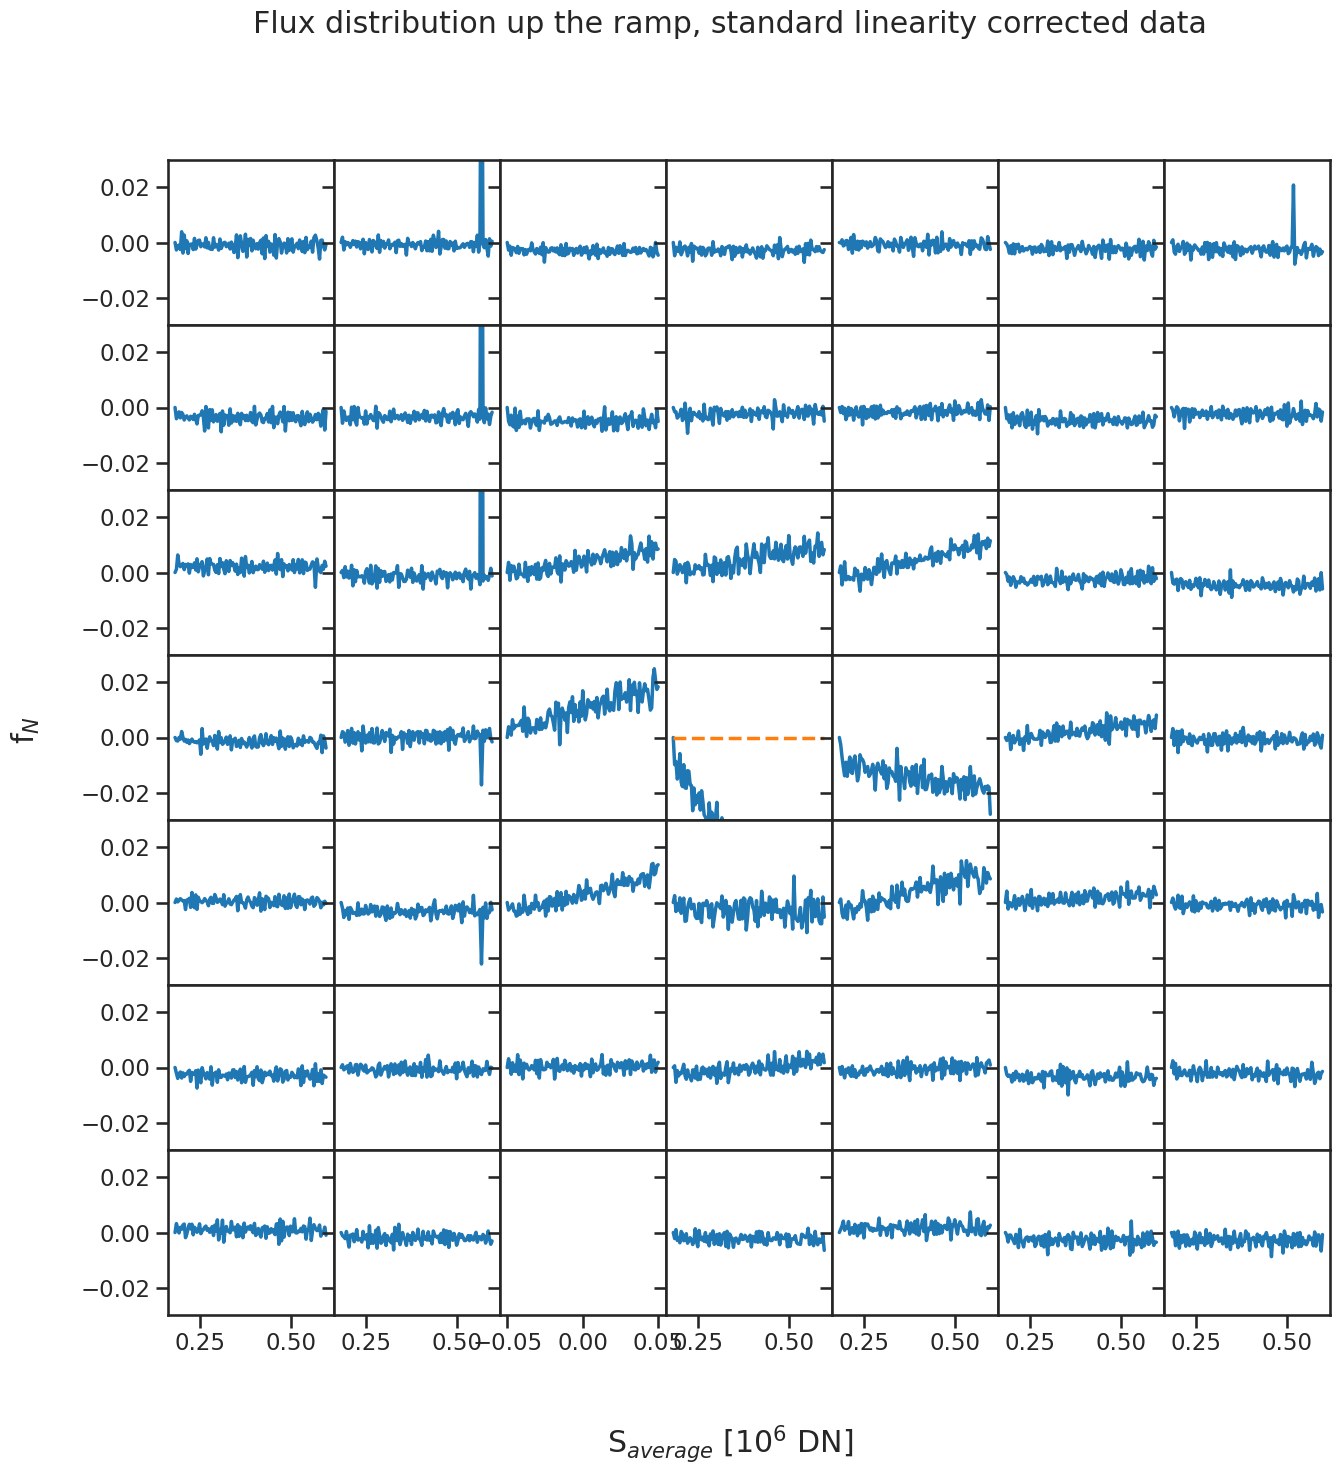

In [94]:
fig, axes = plt.subplots(fN.shape[-2], fN.shape[-1], figsize=(15,15))

for i in range(fN.shape[-2]):
    for j in range(fN.shape[-1]):
        axes[i,j].plot(Sav/1.e6, fN[:, i,j])
        if (j==fN.shape[-2]//2) and (i==fN.shape[-1]//2):
            axes[i,j].plot(Sav/1.e6, Sav*0, '--')
        axes[i,j].set_ylim([-0.0295, 0.0295])
        
        #x_labels = [ 0.6, 0.7, 0.8, 0.9]
        #x_positions = [np.searchsorted(Sav/1.e6, value, side="left") for value in x_labels]
        ##x_labels = ['{:,.0f}'.format(x) for x in x_labels ]
        #axes[i,j].set_xticks(x_positions, x_labels)
        #axes[i,j].set_xlim([0.3, 1.25])
        
        if j != 0:
            axes[i,j].set_yticklabels([])
        if i != fN.shape[-2]-1:
            axes[i,j].set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

fig.supylabel('f$_N$')

fig.supxlabel('S$_{average}$ [10$^6$ DN]')

fig.suptitle('Flux distribution up the ramp, standard linearity corrected data')

plt.show()

Again, one can see that the standard linearity correction for a point source compared to the uncorrected data corrects a large fraction of the non-linearity going up the ramp but still a substantial non-linearity remains. The central pixls are still, relatively loosing flux while the pixels in the wings of the psf are ganing signal as can be seen in the above plot.  

Next,  we check how things look like when aplying the BFE correction. 

In [95]:
target_sub_cube = linearized_data_cube[target_slice_cube][sub_slice]

In [96]:
Fk = np.ma.median(np.ma.diff(target_sub_cube, axis=1), axis=0)
F1 = Fk[0:1, ...]
Fstar = np.ma.sum(np.ma.median(target_sub_cube[:,-1,  ...] - target_sub_cube[:, 0, ...], axis=0)  , axis=(-2,-1))/(nframes-nframe_start-1-1)

In [97]:
fN = ((Fk-F1).T/ Fstar).T

In [98]:
Sav = np.ma.median(np.ma.sum(target_sub_cube[:, :-1, ...] + np.ma.diff(target_sub_cube, axis=1)/2.0, axis=(-2,-1)), axis=0)

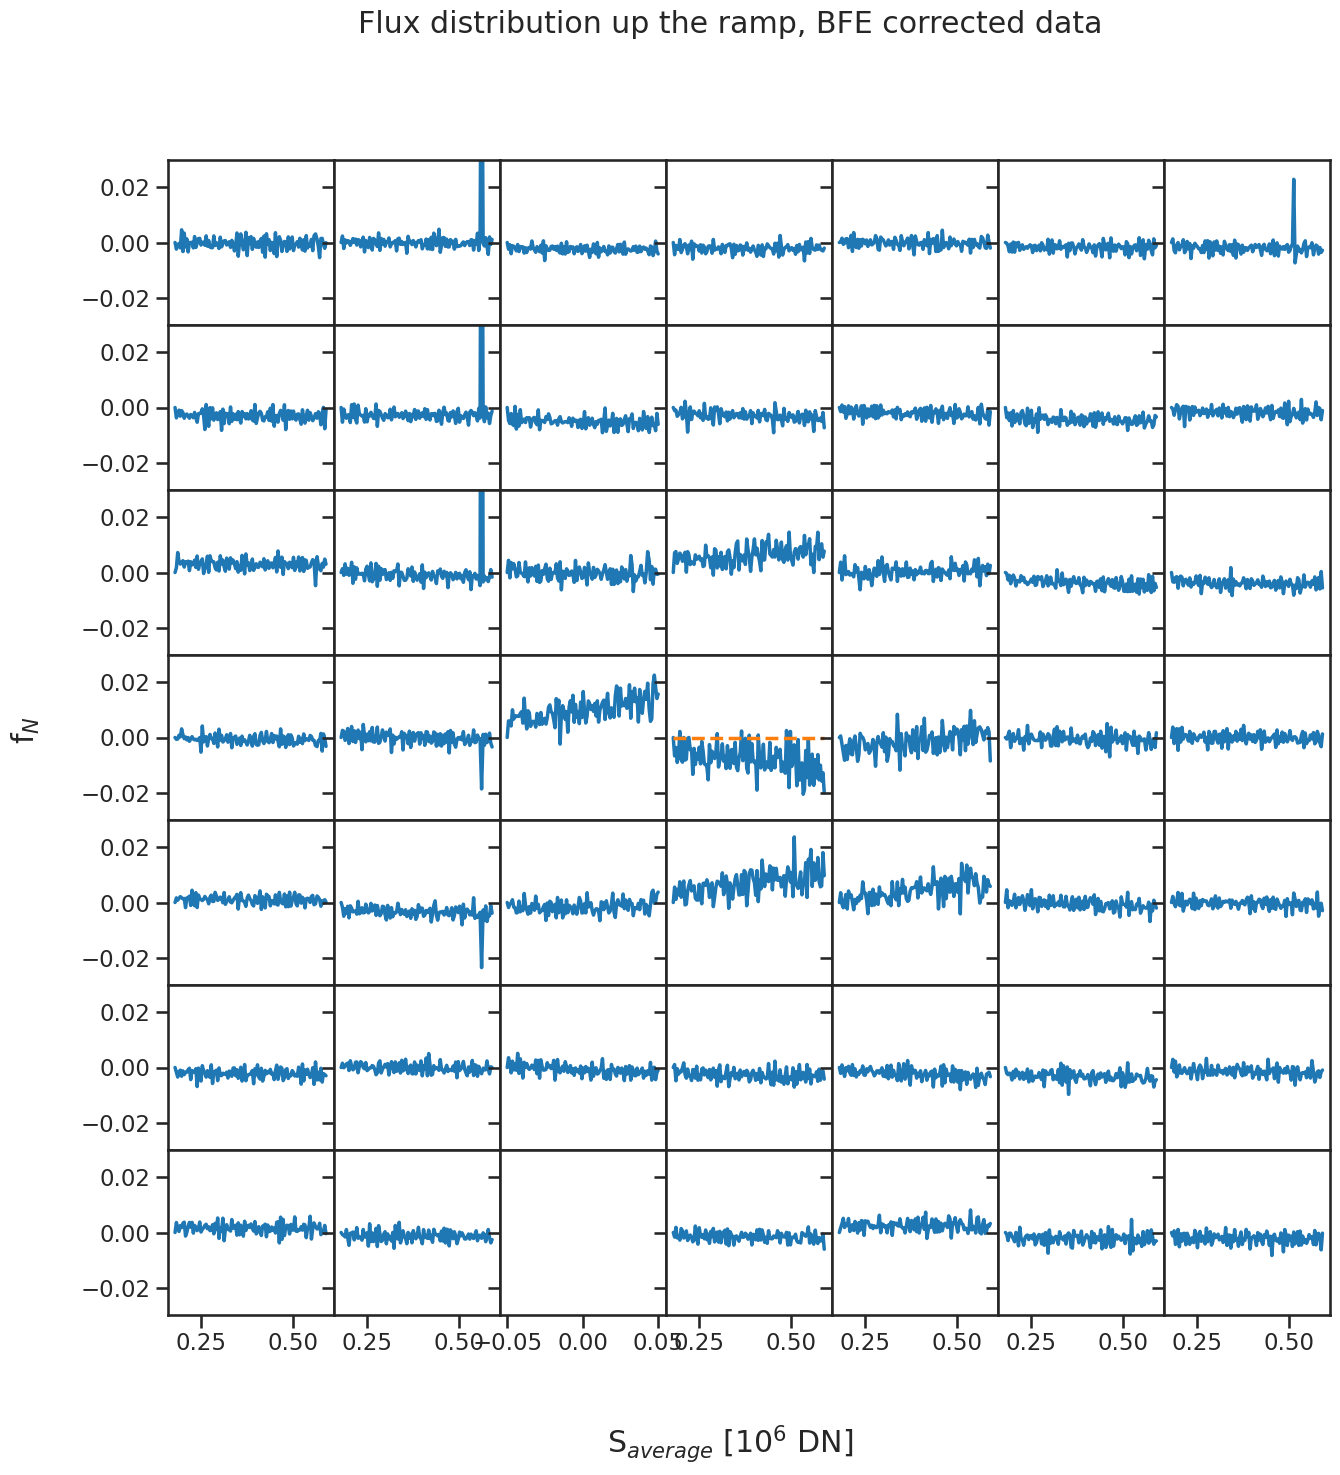

In [99]:
fig, axes = plt.subplots(fN.shape[-2], fN.shape[-1], figsize=(15,15))

for i in range(fN.shape[-2]):
    for j in range(fN.shape[-1]):
        axes[i,j].plot(Sav/1.e6, fN[:, i,j])
        if (j==fN.shape[-2]//2) and (i==fN.shape[-1]//2):
            axes[i,j].plot(Sav/1.e6, Sav*0, '--')
        axes[i,j].set_ylim([-0.0295, 0.0295])
        
        #x_labels = [ 0.6, 0.7, 0.8, 0.9]
        #x_positions = [np.searchsorted(Sav/1.e6, value, side="left") for value in x_labels]
        ##x_labels = ['{:,.0f}'.format(x) for x in x_labels ]
        #axes[i,j].set_xticks(x_positions, x_labels)
        #axes[i,j].set_xlim([0.3, 1.25])
        
        if j != 0:
            axes[i,j].set_yticklabels([])
        if i != fN.shape[-2]-1:
            axes[i,j].set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

fig.supylabel('f$_N$')

fig.supxlabel('S$_{average}$ [10$^6$ DN]')

fig.suptitle('Flux distribution up the ramp, BFE corrected data')

plt.show()

This is a big improvement compared to the standard liniared data and the uncorrected data. Most of the non linear behaviour is completely remocved from the data. For completeness, we also check of the BFE correction based on the time averaged data also gives a similar result:

In [100]:
target_sub_cube = linearized_data_cube_time_av[target_slice_cube][sub_slice]

In [101]:
Fk = np.ma.median(np.ma.diff(target_sub_cube, axis=1), axis=0)
F1 = Fk[0:1, ...]
Fstar = np.ma.sum(np.ma.median(target_sub_cube[:,-1,  ...] - target_sub_cube[:, 0, ...], axis=0)  , axis=(-2,-1))/(nframes-nframe_start-1-1)

In [102]:
fN = ((Fk-F1).T/ Fstar).T

In [103]:
Sav = np.ma.median(np.ma.sum(target_sub_cube[:, :-1, ...] + np.ma.diff(target_sub_cube, axis=1)/2.0, axis=(-2,-1)), axis=0)

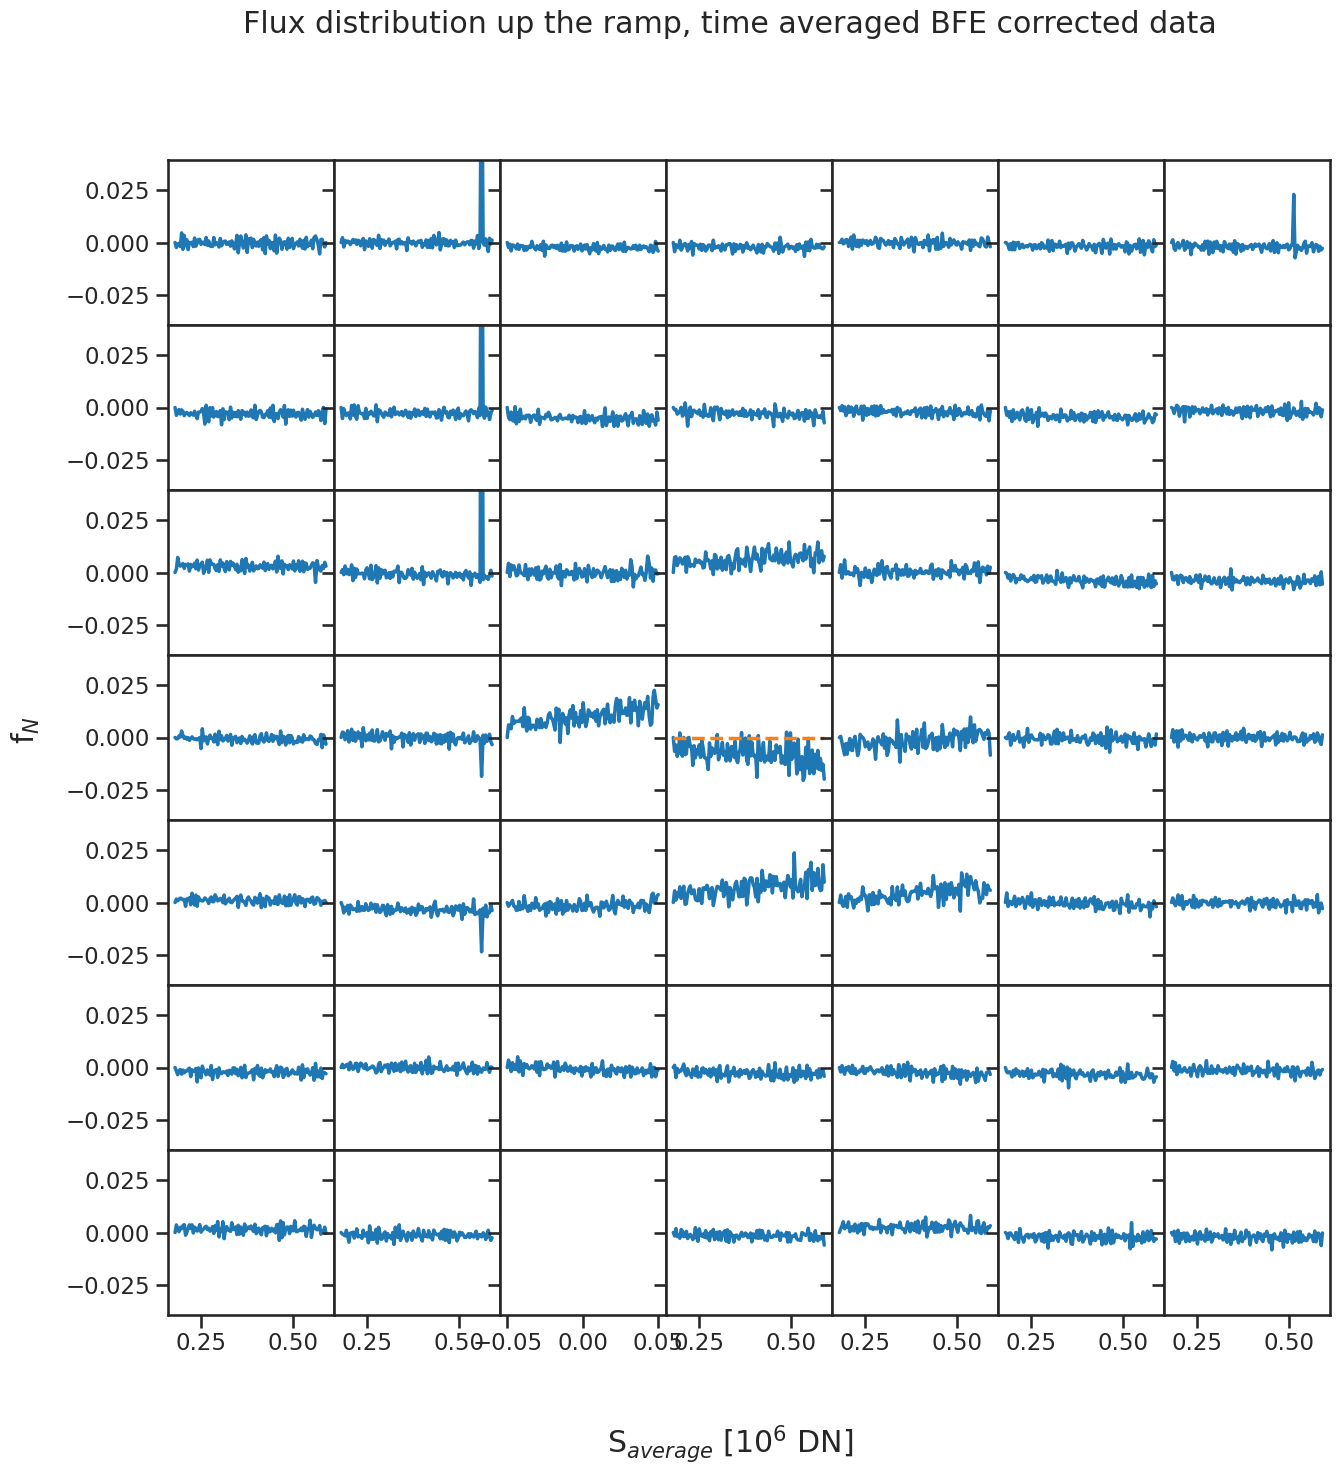

In [104]:
fig, axes = plt.subplots(fN.shape[-2], fN.shape[-1], figsize=(15,15))

for i in range(fN.shape[-2]):
    for j in range(fN.shape[-1]):
        axes[i,j].plot(Sav/1.e6, fN[:, i,j])
        if (j==fN.shape[-2]//2) and (i==fN.shape[-1]//2):
            axes[i,j].plot(Sav/1.e6, Sav*0, '--')
        axes[i,j].set_ylim([-0.039, 0.039])
        
        #x_labels = [ 0.6, 0.7, 0.8, 0.9]
        #x_positions = [np.searchsorted(Sav/1.e6, value, side="left") for value in x_labels]
        ##x_labels = ['{:,.0f}'.format(x) for x in x_labels ]
        #axes[i,j].set_xticks(x_positions, x_labels)
        #axes[i,j].set_xlim([0.3, 1.25])
        
        if j != 0:
            axes[i,j].set_yticklabels([])
        if i != fN.shape[-2]-1:
            axes[i,j].set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

fig.supylabel('f$_N$')

fig.supxlabel('S$_{average}$ [10$^6$ DN]')

fig.suptitle('Flux distribution up the ramp, time averaged BFE corrected data')

plt.show()

As aspected from our previous analysis, the BFE correction based on the time averaged data gives an identical result.

## Check of the effect on the shape of the PSF

we revisit the effect linearization has on the PSF shape. We now also look at the FWHM of the PSF. First we define some functions:

#### define profiles along the detecor row and column through the psf

In [105]:
def create_profile(image, y_center, x_center, n_width, n_sample):

    y,x = np.mgrid[0:image.shape[0]:1, 0:image.shape[1]:1]

    #cross section in x direction
    x_line = ((y_center, x_center-n_width/2 ), (y_center, x_center+n_width/2))

    # Convert the line to pixel/index coordinates
    x_world_xcut, y_world_xcut = np.array(list(zip(*x_line)))
    row_xcut = image.shape[1] * (x_world_xcut - x.min()) / x.ptp()
    col_xcut = image.shape[0] * (y_world_xcut - y.min()) / y.ptp()

    # Interpolate the line at "num" points...
    row_xcut, col_xcut = [np.linspace(item[0], item[1], n_sample) for item in [row_xcut, col_xcut]]

    # Extract the values along the line, using cubic interpolation
    #zi = scipy.ndimage.map_coordinates(z, np.vstack((row, col)))
    x_cut = scipy.ndimage.map_coordinates(image, np.vstack((row_xcut, col_xcut)), order=4)

    #cross section in y direction
    y_line = ((y_center-n_width/2, x_center), (y_center+n_width/2, x_center))

    # Convert the line to pixel/index coordinates
    x_world_ycut, y_world_ycut = np.array(list(zip(*y_line)))
    row_ycut = image.shape[1] * (x_world_ycut - x.min()) / x.ptp()
    col_ycut = image.shape[0] * (y_world_ycut - y.min()) / y.ptp()

    # Interpolate the line at "num" points...
    row_ycut, col_ycut = [np.linspace(item[0], item[1], n_sample) for item in [row_ycut, col_ycut]]

    # Extract the values along the line, using cubic interpolation
    #zi = scipy.ndimage.map_coordinates(z, np.vstack((row, col)))
    y_cut = scipy.ndimage.map_coordinates(image, np.vstack((row_ycut, col_ycut)), order=4)

    world_coordinates = [[x_world_xcut, y_world_xcut], [x_world_ycut, y_world_ycut]]

    return x_cut, col_xcut, y_cut, row_ycut, world_coordinates


#### Define the FWHM

In [106]:
def half_max_x(x, y):
    # create a spline of x and blue-np.max(blue)/2 
    spline = UnivariateSpline(x, y-np.max(y)/2, s=0)
    r = spline.roots() # find the roots
    return r[0], r[1]

def calc_fwhm(x, y):
    # find the two crossing points
    hmx = half_max_x(x,y)
    # fwhm
    fwhm = (hmx[1] - hmx[0])
    return fwhm

#### Determine the background

In [131]:
def determine_background(data_cube):
    
    image = np.ma.median(data_cube, axis=0)
    mask = image.mask
    coverage_mask = (image == 0)
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    threshold = detect_threshold(image, nsigma=3.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(image, threshold, npixels=11, connectivity=8, mask=mask)

    footprint = circular_footprint(radius=5)    
    
    background_cube = []
    for image , mask in zip(data_cube, data_cube.mask):

        if np.all(mask):
            background_cube.append(image*0)
            continue
            
        #background_comp1 = np.zeros_like(image)
        #background_comp1 = background_comp1 + np.ma.median(image, axis=0)
        #background_comp1 = (background_comp1.T + np.ma.median(image, axis=1)).T
        #image = image - background_comp1

        #coverage_mask = (image == 0)
        #sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
        #threshold = detect_threshold(image, nsigma=3.0, sigma_clip=sigma_clip)
        #segment_img = detect_sources(image, threshold, npixels=11, connectivity=8, mask=mask)

        #footprint = circular_footprint(radius=5)
        mask_background = segment_img.make_source_mask(footprint=footprint) | mask
        bkground = Background2D(image,(5, 5), filter_size=(1,1),mask=mask_background,coverage_mask=coverage_mask)
        background_comp2 = bkground.background

        #background_up_the_ramp.append(background_comp1 + background_comp2)
        background_cube.append(background_comp2)

    background_cube = np.array(background_cube)
    return background_cube

#### Calculate the background subtracted fluxes for the different linearization methods. 

In [108]:
flux_up_the_ramp_standard_linearized = np.ma.diff(np.ma.mean(standard_linearized_data_cube[target_slice_cube], axis=0), axis=0)
background_up_the_ramp_standard_linearized = determine_background(flux_up_the_ramp_standard_linearized)
flux_up_the_ramp_standard_linearized -= np.median(background_up_the_ramp_standard_linearized, axis=0)
flux_up_the_ramp_standard_linearized = sigma_clip(flux_up_the_ramp_standard_linearized, sigma=5.0, axis=0,
                                                  cenfunc='median', stdfunc='mad_std')
flux_standard_linearized = np.ma.mean(flux_up_the_ramp_standard_linearized, axis=0)

In [133]:
flux_up_the_ramp_linearized = np.ma.diff(np.ma.mean(linearized_data_cube[target_slice_cube], axis=0), axis=0)
background_up_the_ramp_linearized = determine_background(flux_up_the_ramp_linearized)
flux_up_the_ramp_linearized -= np.median(background_up_the_ramp_linearized, axis=0)
flux_up_the_ramp_linearized = sigma_clip(flux_up_the_ramp_linearized, sigma=5.0, axis=0,
                                                  cenfunc='median', stdfunc='mad_std')
flux_linearized = np.ma.mean(flux_up_the_ramp_linearized, axis=0)

In [134]:
flux_up_the_ramp_time_averaged_linearized = np.ma.diff(np.ma.mean(linearized_data_cube_time_av[target_slice_cube], axis=0), axis=0)
background_up_the_ramp_time_averaged_linearized = determine_background(flux_up_the_ramp_time_averaged_linearized)
flux_up_the_ramp_time_averaged_linearized -= np.median(background_up_the_ramp_time_averaged_linearized, axis=0)
flux_up_the_ramp_time_averaged_linearized = sigma_clip(flux_up_the_ramp_time_averaged_linearized, sigma=5.0, axis=0,
                                                  cenfunc='median', stdfunc='mad_std')
flux_time_averaged_linearized = np.ma.mean(flux_up_the_ramp_time_averaged_linearized, axis=0)

#### Determine the exact source position.

In [135]:
mean, median, std = sigma_clipped_stats(flux_linearized, sigma=5.0)  
daofind = DAOStarFinder(fwhm=4.3, threshold=70.*std, sigma_radius=1.35)  
sources = daofind(flux_linearized - median)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output

source_position = (sources[0]['ycentroid'], sources[0]['xcentroid'])

print(f'Target location: {sources[0]}')

Target location:  id xcentroid ycentroid sharpness   roundness1  roundness2 npix sky   peak      flux      mag    
--- --------- --------- ---------- ----------- ----------- ---- --- -------- --------- ----------
  1 18.178964 17.111693 0.64045706 0.070977896 -0.01392943   25   0 691.2632 14.340977 -2.8914469


#### Create the cross sections and deterine the FWHM

In [136]:
# cross-cut in a and y direction
x_cut, col_xcut, y_cut, row_ycut, world_coordinates = create_profile(flux_standard_linearized, source_position[0], source_position[1], 20.0, 121)
 
 # fwhm calculation   
x = col_xcut-source_position[1]
y  = x_cut
fwhm_x = calc_fwhm(x, y)

x = row_ycut-source_position[0]
y  = y_cut
fwhm_y = calc_fwhm(x, y)

In [137]:
# interpolation kernel to fix bad data
gauss = Gaussian2DKernel(x_stddev=1)

In [138]:
fwhm_x_up_the_ramp =[]
fwhm_y_up_the_ramp =[]
for i in range(flux_up_the_ramp_standard_linearized.shape[0]):
    # cross-cut in a and y direction
    
    if np.all(flux_up_the_ramp_standard_linearized[i, ...].mask):
        fwhm_x_up_the_ramp.append(np.nan)
        fwhm_y_up_the_ramp.append(np.nan)
        continue
    
    image = flux_up_the_ramp_standard_linearized[i, ...]
    image = interpolate_replace_nans(image.filled(np.nan), gauss)
    x_cut_utr, col_xcut_utr, y_cut_utr, row_ycut_utr, world_coordinates_utr = \
    create_profile(image, source_position[0], source_position[1], 20.0, 121)

     # fwhm calculation   
    x = col_xcut_utr-source_position[1]
    #y = interpolate_replace_nans(x_cut_utr.filled(np.nan), gauss)
    #y  = scipy.signal.medfilt(x_cut_utr, kernel_size=(3))
    y = x_cut_utr
    fwhm_x_up_the_ramp.append(calc_fwhm(x, y))

    x = row_ycut_utr-source_position[0]
    y = y_cut_utr
    fwhm_y_up_the_ramp.append(calc_fwhm(x, y))

In [139]:
# cross-cut in a and y direction
x_cut_linearized, col_xcut_linearized, y_cut_linearized, row_ycut_linearized, world_coordinates_linearized = \
create_profile(flux_linearized, source_position[0], source_position[1], 20.0, 121)
 
 # fwhm calculation   
x = col_xcut_linearized-source_position[1]
y  = x_cut_linearized
fwhm_x_linearized = calc_fwhm(x, y)

x = row_ycut_linearized-source_position[0]
y  = y_cut_linearized
fwhm_y_linearized = calc_fwhm(x, y)

In [140]:
fwhm_x_up_the_ramp_linearized =[]
fwhm_y_up_the_ramp_linearized =[]
for i in range(flux_up_the_ramp_linearized.shape[0]):
    
    if np.all(flux_up_the_ramp_standard_linearized[i, ...].mask):
        fwhm_x_up_the_ramp_linearized.append(np.nan)
        fwhm_y_up_the_ramp_linearized.append(np.nan)
        continue
    
    # cross-cut in a and y direction
    image = flux_up_the_ramp_linearized[i, ...]
    image = interpolate_replace_nans(image.filled(np.nan), gauss)
    x_cut_utr, col_xcut_utr, y_cut_utr, row_ycut_utr, world_coordinates_utr = \
    create_profile(image, source_position[0], source_position[1], 20.0, 121)

     # fwhm calculation   
    x = col_xcut_utr-source_position[1]
    y  = x_cut_utr
    fwhm_x_up_the_ramp_linearized.append(calc_fwhm(x, y))

    x = row_ycut_utr-source_position[0]
    y  = y_cut_utr
    fwhm_y_up_the_ramp_linearized.append(calc_fwhm(x, y))

In [141]:
# cross-cut in a and y direction
x_cut_time_averaged_linearized, col_xcut_time_averaged_linearized, y_cut_time_averaged_linearized, row_ycut_time_averaged_linearized, world_coordinates_time_averaged_linearized = \
create_profile(flux_time_averaged_linearized, source_position[0], source_position[1], 20.0, 121)
 
 # fwhm calculation   
x = col_xcut_time_averaged_linearized-source_position[1]
y  = x_cut_time_averaged_linearized
fwhm_x_time_averaged_linearized = calc_fwhm(x, y)

x = row_ycut_time_averaged_linearized-source_position[0]
y  = y_cut_time_averaged_linearized
fwhm_y_time_averaged_linearized = calc_fwhm(x, y)

In [142]:
fwhm_x_up_the_ramp_time_averaged_linearized =[]
fwhm_y_up_the_ramp_time_averaged_linearized =[]
for i in range(flux_up_the_ramp_time_averaged_linearized.shape[0]):
    
    if np.all(flux_up_the_ramp_time_averaged_linearized[i, ...].mask):
        fwhm_x_up_the_ramp_time_averaged_linearized.append(np.nan)
        fwhm_y_up_the_ramp_time_averaged_linearized.append(np.nan)
        continue
    
    # cross-cut in a and y direction
    image = flux_up_the_ramp_time_averaged_linearized[i, ...]
    image = interpolate_replace_nans(image.filled(np.nan), gauss)
    x_cut_utr, col_xcut_utr, y_cut_utr, row_ycut_utr, world_coordinates_utr = \
    create_profile(image, source_position[0], source_position[1], 20.0, 121)

     # fwhm calculation   
    x = col_xcut_utr-source_position[1]
    y  = x_cut_utr
    fwhm_x_up_the_ramp_time_averaged_linearized.append(calc_fwhm(x, y))

    x = row_ycut_utr-source_position[0]
    y  = y_cut_utr
    fwhm_y_up_the_ramp_time_averaged_linearized.append(calc_fwhm(x, y))

#### plot the cross sections for the 3 different linearizations.

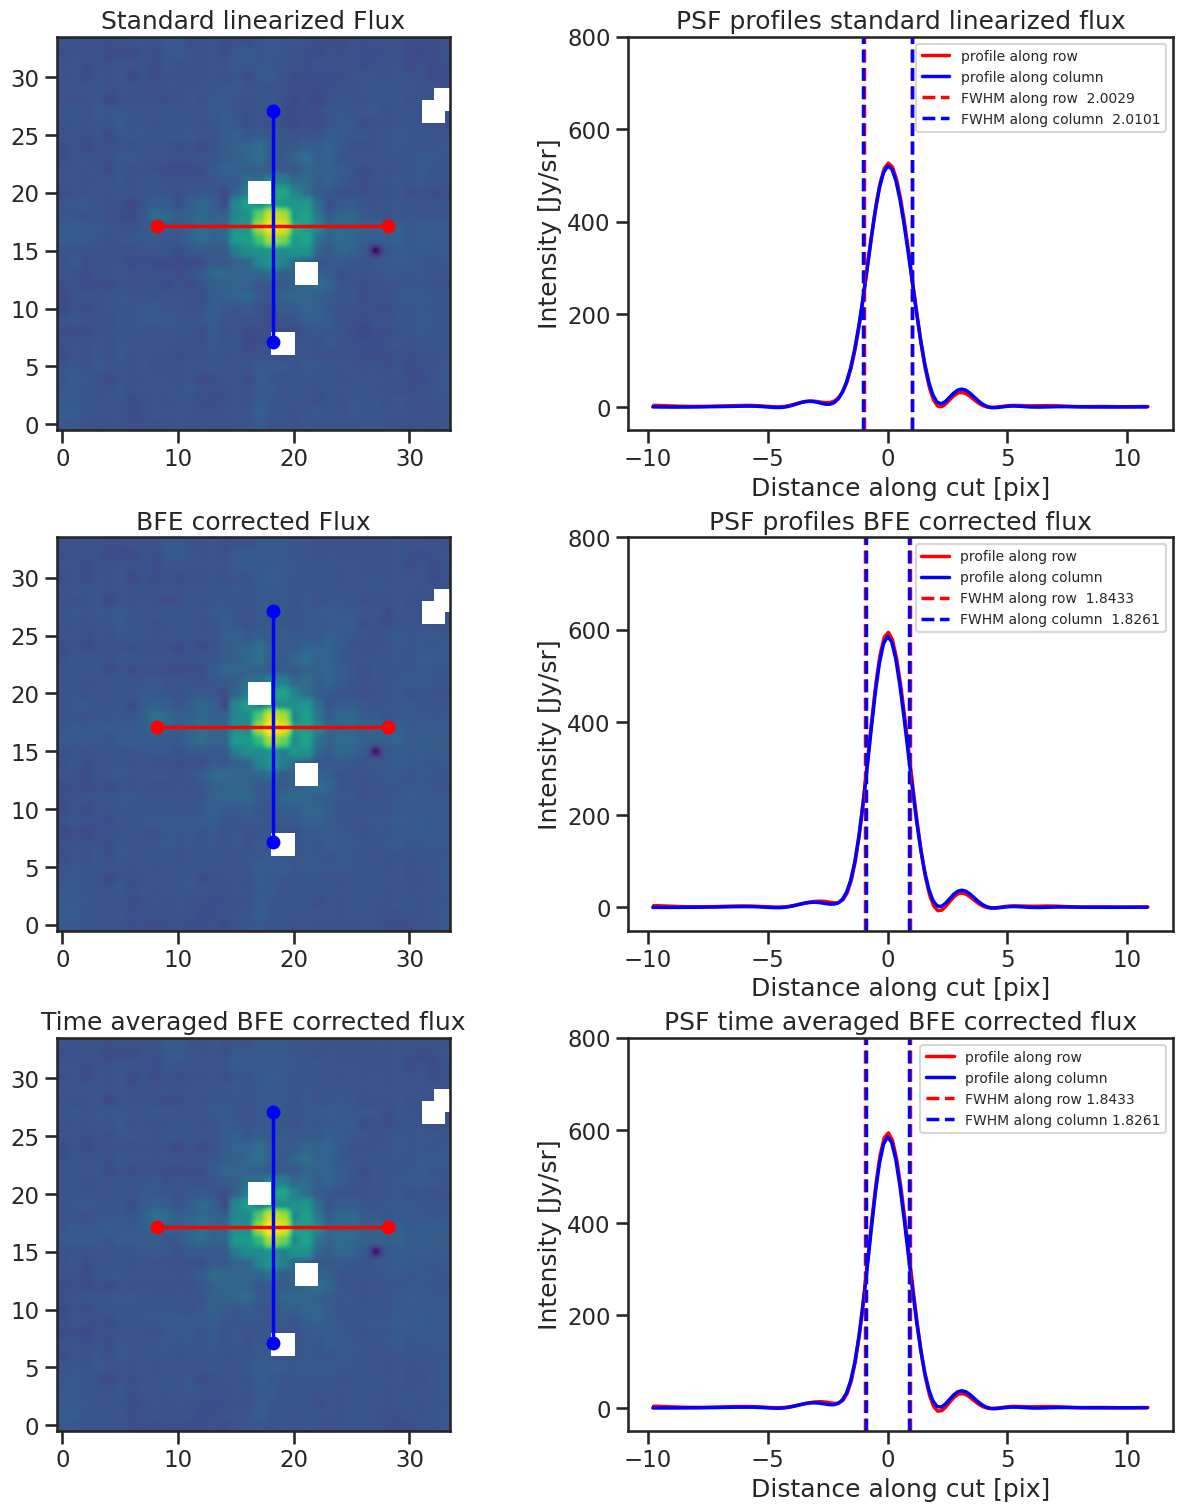

In [143]:
# Plot...
fig, axes = plt.subplots(3,2, figsize=(12,15), constrained_layout=True)
interval = MinMaxInterval()
vmin, vmax = interval.get_limits(flux_standard_linearized.filled(0))
stretch = LogStretch()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)

im1 = axes[0, 0].imshow(flux_standard_linearized,  cmap='viridis', origin='lower', norm=norm,
                       interpolation='hanning')
axes[0,0].plot(world_coordinates[0][1], world_coordinates[0][0], 'ro-')
axes[0,0].plot(world_coordinates[1][1], world_coordinates[1][0], 'bo-')
axes[0,0].set_title('Standard linearized Flux')
axes[0,1].plot(col_xcut-source_position[1], x_cut, color='r', label='profile along row')
axes[0,1].plot(row_ycut-source_position[0], y_cut, color='b', label='profile along column')
axes[0,1].axvline(x=-fwhm_x/2, color='r', ls='--', label=f'FWHM along row {fwhm_x: .4f}')
axes[0,1].axvline(x=fwhm_x/2, color='r', ls='--')
axes[0,1].axvline(x=-fwhm_y/2, color='b', ls='--', label=f'FWHM along column {fwhm_y: .4f}')
axes[0,1].axvline(x=fwhm_y/2, color='b', ls='--')
axes[0,1].set_title('PSF profiles standard linearized flux')
axes[0,1].set_xlabel('Distance along cut [pix]')
axes[0,1].set_ylabel('Intensity [Jy/sr]')
axes[0,1].legend(fontsize=10)


im1 = axes[1, 0].imshow(flux_linearized,  cmap='viridis', origin='lower', norm=norm,
                       interpolation='hanning')
axes[1,0].plot(world_coordinates_linearized[0][1], world_coordinates_linearized[0][0], 'ro-')
axes[1,0].plot(world_coordinates_linearized[1][1], world_coordinates_linearized[1][0], 'bo-')
axes[1,0].set_title('BFE corrected Flux')
axes[1,1].plot(col_xcut_linearized-source_position[1], x_cut_linearized, color='r', label='profile along row')
axes[1,1].plot(row_ycut_linearized-source_position[0], y_cut_linearized, color='b', label='profile along column')
axes[1,1].axvline(x=-fwhm_x_linearized/2, color='r', ls='--', label=f'FWHM along row {fwhm_x_linearized: .4f}')
axes[1,1].axvline(x=fwhm_x_linearized/2, color='r', ls='--')
axes[1,1].axvline(x=-fwhm_y_linearized/2, color='b', ls='--', label=f'FWHM along column {fwhm_y_linearized: .4f}')
axes[1,1].axvline(x=fwhm_y_linearized/2, color='b', ls='--')
axes[1,1].set_title('PSF profiles BFE corrected flux')
axes[1,1].set_xlabel('Distance along cut [pix]')
axes[1,1].set_ylabel('Intensity [Jy/sr]')
axes[1,1].legend(fontsize=10)


im1 = axes[2, 0].imshow(flux_time_averaged_linearized,  cmap='viridis', origin='lower', norm=norm,
                       interpolation='hanning')
axes[2,0].plot(world_coordinates_time_averaged_linearized[0][1], world_coordinates_time_averaged_linearized[0][0], 'ro-')
axes[2,0].plot(world_coordinates_time_averaged_linearized[1][1], world_coordinates_time_averaged_linearized[1][0], 'bo-')
axes[2,0].set_title('Time averaged BFE corrected flux')
axes[2,1].plot(col_xcut_time_averaged_linearized-source_position[1], x_cut_time_averaged_linearized, color='r', label='profile along row')
axes[2,1].plot(row_ycut_time_averaged_linearized-source_position[0], y_cut_time_averaged_linearized, color='b', label='profile along column')
axes[2,1].axvline(x=-fwhm_x_time_averaged_linearized/2, color='r', ls='--', label=f'FWHM along row {fwhm_x_time_averaged_linearized:.4f}')
axes[2,1].axvline(x=fwhm_x_time_averaged_linearized/2, color='r', ls='--')
axes[2,1].axvline(x=-fwhm_y_time_averaged_linearized/2, color='b', ls='--', label=f'FWHM along column {fwhm_y_time_averaged_linearized:.4f}')
axes[2,1].axvline(x=fwhm_y_time_averaged_linearized/2, color='b', ls='--')
axes[2,1].set_title('PSF time averaged BFE corrected flux')
axes[2,1].set_xlabel('Distance along cut [pix]')
axes[2,1].set_ylabel('Intensity [Jy/sr]')
axes[2,1].legend(fontsize=10)

axes[0,1].set_ylim([-50, 800])
axes[1,1].set_ylim([-50, 800])
axes[2,1].set_ylim([-50, 800])

plt.show()

In [144]:
# cross-cut in a and y direction
x_cut_webb, col_xcut_webb, y_cut_webb, row_ycut_webb, world_coordinates_webb = create_profile(offset_psf_image-7.0, source_position[0], source_position[1], 20.0, 121)
 
 # fwhm calculation   
x = col_xcut_webb-source_position[1]
y  = x_cut_webb
fwhm_x_webb = calc_fwhm(x, y)

x = row_ycut_webb-source_position[0]
y  = y_cut_webb
fwhm_y_webb = calc_fwhm(x, y)

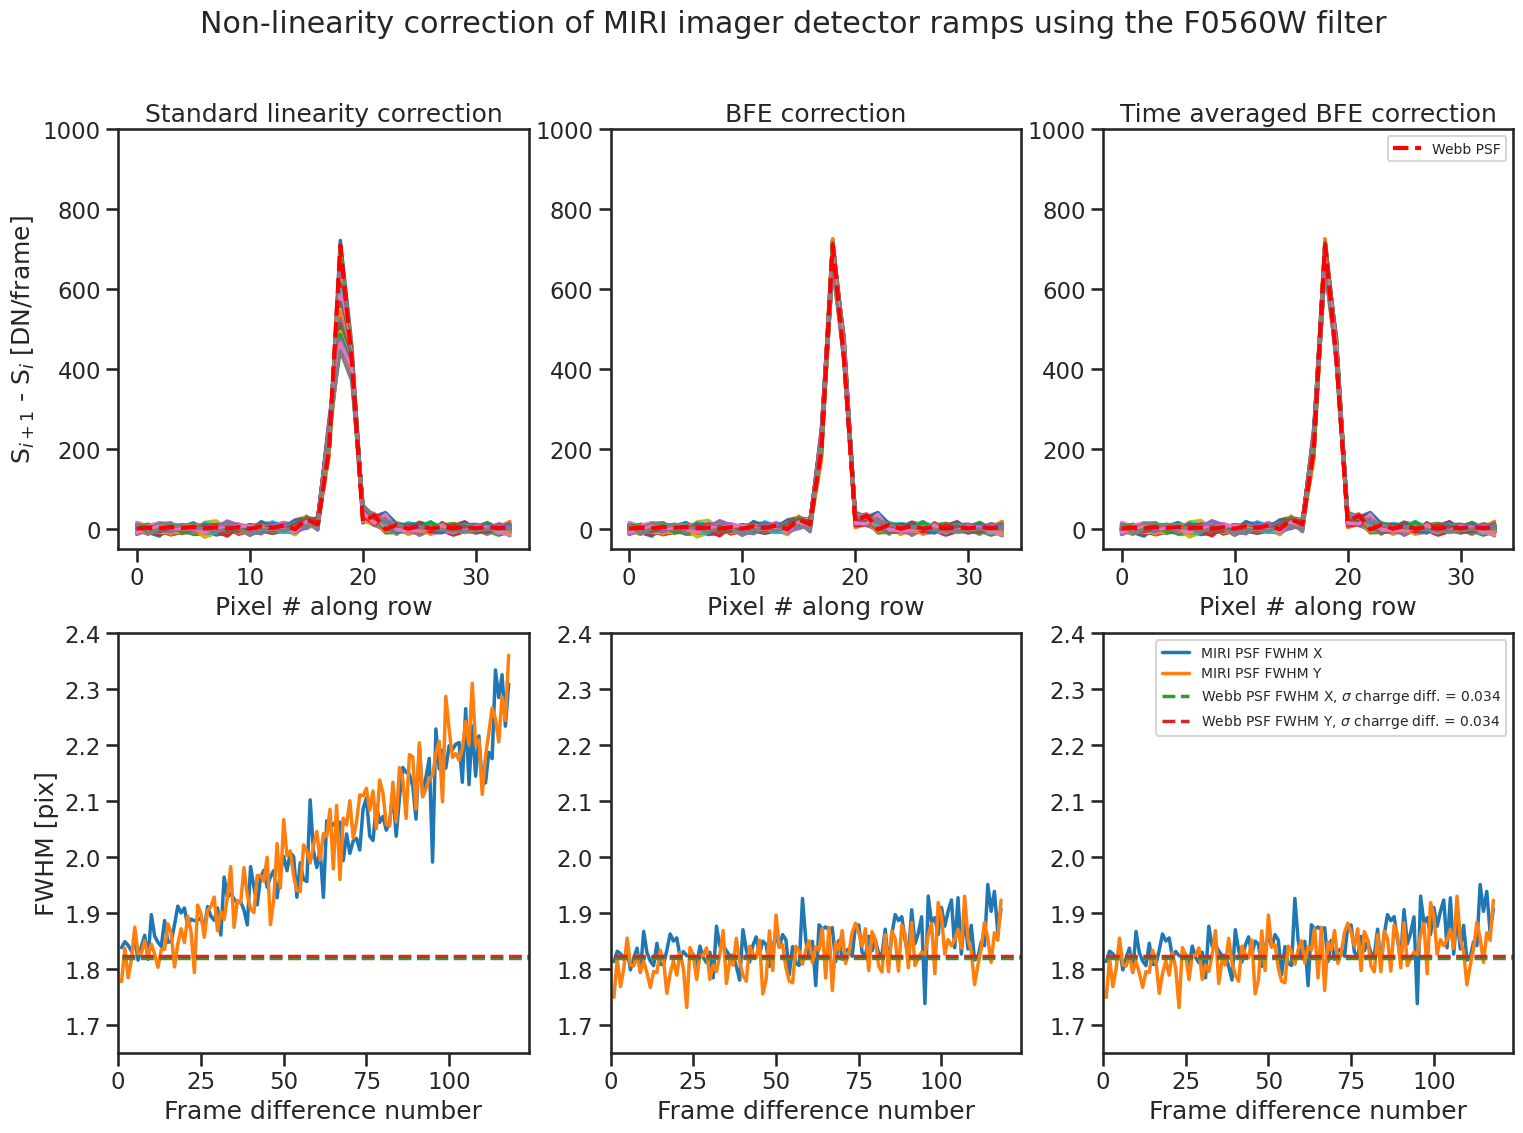

In [145]:
fig, axes = plt.subplots(2,3, figsize=(18,12))
axes[0, 0].plot(flux_up_the_ramp_standard_linearized[:, max_indx[0], :].T)
axes[0, 0].plot(offset_psf_image[max_indx[0], :]-7, '--', lw=3, color='red')
axes[0, 1].plot(flux_up_the_ramp_linearized[:, max_indx[0], :].T)
axes[0, 1].plot(offset_psf_image[max_indx[0], :]-7, '--', lw=3, color='red')
axes[0, 2].plot(flux_up_the_ramp_time_averaged_linearized[:, max_indx[0], :].T)
axes[0, 2].plot(offset_psf_image[max_indx[0], :]-7, '--', lw=3, color='red', label='Webb PSF')

axes[0, 0].set_ylim([-50, 1000])
axes[0, 1].set_ylim([-50, 1000])
axes[0, 2].set_ylim([-50, 1000])

axes[0, 0].set_ylabel('S$_{i+1}$ - S$_i$ [DN/frame]')
axes[0, 0].set_xlabel('Pixel # along row')
axes[0, 1].set_xlabel('Pixel # along row')
axes[0, 2].set_xlabel('Pixel # along row')

axes[0, 0].set_title('Standard linearity correction')
axes[0, 1].set_title('BFE correction')
axes[0, 2].set_title('Time averaged BFE correction')

axes[1,0].plot(np.arange(nframes-3-nframes_max)+1, fwhm_x_up_the_ramp)
axes[1,1].plot(np.arange(nframes-3-nframes_max)+1, fwhm_x_up_the_ramp_linearized)
axes[1,2].plot(np.arange(nframes-3-nframes_max)+1, fwhm_x_up_the_ramp_time_averaged_linearized, label='MIRI PSF FWHM X')
axes[1,0].plot(np.arange(nframes-3-nframes_max)+1, fwhm_y_up_the_ramp)
axes[1,1].plot(np.arange(nframes-3-nframes_max)+1, fwhm_y_up_the_ramp_linearized)
axes[1,2].plot(np.arange(nframes-3-nframes_max)+1, fwhm_y_up_the_ramp_time_averaged_linearized, label='MIRI PSF FWHM Y')
axes[1,0].plot([1,124], [fwhm_x_webb, fwhm_x_webb], '--', label=f'Webb PSF FWHM X, $\sigma$ charrge diff. = {sim_inst.options["charge_diffusion_sigma"]}')
axes[1,0].plot([1,124], [fwhm_y_webb,fwhm_y_webb], '--', label=f'Webb PSF FWHM Y, $\sigma$ charrge diff. = {sim_inst.options["charge_diffusion_sigma"]}' )
axes[1,1].plot([1,124], [fwhm_x_webb, fwhm_x_webb], '--', label=f'Webb PSF FWHM X, $\sigma$ charrge diff. = {sim_inst.options["charge_diffusion_sigma"]}')
axes[1,1].plot([1,124], [fwhm_y_webb,fwhm_y_webb], '--', label=f'Webb PSF FWHM Y, $\sigma$ charrge diff. = {sim_inst.options["charge_diffusion_sigma"]}' )
axes[1,2].plot([1,124], [fwhm_x_webb, fwhm_x_webb], '--', label=f'Webb PSF FWHM X, $\sigma$ charrge diff. = {sim_inst.options["charge_diffusion_sigma"]}')
axes[1,2].plot([1,124], [fwhm_y_webb,fwhm_y_webb], '--', label=f'Webb PSF FWHM Y, $\sigma$ charrge diff. = {sim_inst.options["charge_diffusion_sigma"]}' )


axes[1, 0].set_ylim([1.65, 2.4])
axes[1, 1].set_ylim([1.65, 2.4])
axes[1, 2].set_ylim([1.65, 2.4])

axes[1, 0].set_xlim([0, 124])
axes[1, 1].set_xlim([0, 124])
axes[1, 2].set_xlim([0, 124])

axes[1, 0].set_ylabel('FWHM [pix]')
axes[1, 0].set_xlabel('Frame difference number')
axes[1, 1].set_xlabel('Frame difference number')
axes[1, 2].set_xlabel('Frame difference number')

axes[0, 2].legend(fontsize=10)
axes[1, 2].legend(fontsize=10)

fig.suptitle('Non-linearity correction of MIRI imager detector ramps using the F0560W filter')
plt.show()